<a id="contents"></a>

# Final Project

- [**Problem Statement**](#rq)

- [**Data Preprocessing**](#datpre)

- [**Summary of Data**](#summary)

- [**Initial EDA**](#initeda)

- [**Base Models**](#basemodels)

- [**Model Pipeline**](#model_select)

- [**Inferences**](#infer)

- [**Pipes**](#f_model_pipe)

<a id="rq"></a>

## Problem Statement

#### Which players are most undervalued, relative to their Tranfermarkt value?

<div style = "background: black; border: thin solid white; border-radius: 2px; padding: 5px">
<details>
<summary> <strong> Column Name Legend </strong> (click)

</summary>

<div style="display: flex; justify-content: center;">

| Column Name | Description |
|------------------|-----------------|
| **Rank:** | Website Index |
| **Player:** | Player Name |
| **Nation:** | Player Nationality |
| **Pos:** | Player Position |
| **Squad:** | Player's Club |
| **Age:** | Player Age |
| **Born:** | Player Year of Birth |
|------------------|-----------------|
| **Playing Time MP:** | Matches Played |
| **Playing Time Starts:** | Matches Started |
| **Playing Time Min:** | Total Minutes Played |
| **Playing Time 90s:** | Number of 90 minute appearances |
|------------------|-----------------|
| **Perfomance Gls:** | goals |
| **Perfomance Ast:** | Assists |
| **Perfomance G+A:** | Goals and Assists |
| **Perfomance G-Pk:** | Goals not counting penalty kicks |
| **Perfomance PK:** | Penalty Kicks made |
| **Perfomance PKatt:** | penalty attempts |
| **Perfomance CrdY:** | yellow cards |
| **Perfomance CrdR:** | red cards |
|------------------|-----------------|
| **Expected xG:** | expected goals |
| **Expected npxG:** | non-penalty expected goals |
| **Expected xA:** | expected assists |
| **Expected npxG+xAG:** | on-penalty expected and assisted goals |
|------------------|-----------------|
| **Progression PrgC:** | completed progressive dribbles |
| **Progression PrgP:** | completed progressive passes |
| **Progression PrgR:** | completed progressive receptions |
|------------------|-----------------|
| **Per 90 Minutes Gls:** | goals (per 90 min) |
| **Per 90 Minutes Ast:** | Assists (per 90 min) |
| **Per 90 Minutes G+A:** | Goals and Assists (per 90 min) |
| **Per 90 Minutes G-Pk:** | Goals not counting penalty kicks (per 90 min) |
| **Per 90 Minutes PK:** | Penalty Kicks made (per 90 min) |
| **Per 90 Minutes PKatt:** | penalty attempts (per 90 min)|
| **Per 90 Minutes CrdY:** | yellow cards (per 90 min) |
| **Per 90 Minutes CrdR:** | red cards (per 90 min) |
| **Per 90 Minutes Expected xG:** | expected goals (per 90 min) |
| **Per 90 Minutes Expected xAG:** | expected assists (per 90 min) |
| **Per 90 Minutes Expected xG+AG:** | expected goals and expected assisted goals (per 90 min) |
| **Per 90 Minutes Expected npxG:** | non-penalty expected goals (per 90 min) |
| **Per 90 Minutes Expected npxG+xAG:** | non-penalty expected and assisted goals (per 90 min) |
| **Market Value_2022:** | Transfermarkt Market Value from prior season |
| **Market Value_2023:** | Transfermarkt Market Value (response variable) |

</div>
</details>
</div>

In [ ]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from bs4 import BeautifulSoup
import pandas as pd
import requests

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.inspection import permutation_importance

In [ ]:
# Load a CSV file. Replace 'path_to_file.csv' with the actual file path.
file_path = '/content/combined_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows to confirm loading
data.head()

Player Nation        Squad  Age  Playing Time MP  \
0         Max Aarons    ENG  Bournemouth   23               20   
1  Joshua Acheampong    ENG      Chelsea   17                1   
2        Tyler Adams    USA  Bournemouth   24                3   
3   Tosin Adarabioyo    ENG       Fulham   25               20   
4     Elijah Adebayo    ENG   Luton Town   25               27   

   Playing Time Starts  Playing Time Min  Playing Time 90s  Performance Gls  \
0                   13              1237              13.7                0   
1                    0                 6               0.1                0   
2                    1               121               1.3                0   
3                   18              1617              18.0                2   
4                   16              1419              15.8               10   

   Performance Ast  ...  Per 90 Minutes G-PK  Per 90 Minutes G+A-PK  \
0                1  ...                 0.00                   0.07   
1                0  ...                 0.00                   0.00   
2                0  ...                 0.00                   0.00   
3                0  ...                 0.11                   0.11   
4                0  ...                 0.63                   0.63   

   Per 90 Minutes xG  Per 90 Minutes xAG  Per 90 Minutes xG+xAG  \
0               0.00                0.06                   0.06   
1               0.00                0.00                   0.00   
2               0.00                0.06                   0.06   
3               0.04                0.01                   0.05   
4               0.37                0.04                   0.42   

   Per 90 Minutes npxG  Per 90 Minutes npxG+xAG            Position  \
0                 0.00                     0.06          Right-Back   
1                 0.00                     0.00          Right-Back   
2                 0.00                     0.06  Defensive Midfield   
3                 0.04                     0.05         Centre-Back   
4                 0.37                     0.42      Centre-Forward   

   Market Value_2023  Market Value_2022  
0           16000000         16000000.0  
1             300000                NaN  
2           15000000         18000000.0  
3           20000000         16000000.0  
4           12000000          6000000.0  

[5 rows x 36 columns]

We scraped two data sources, [Transfermarkt](transfermarkt.us) and [FBRef](FBRef.com). Transfermarkt provides all data pertaining to the market value of players throughout their careers. FBRef offers an overview of the performance statistics of an individual player throughout the season. We combined the two dataframes using the player names, although the use of the fuzzywuzzy library and some manual renaming was necessary to overcome discrepancies in naming conventions.

*The result of our scraping and merging of data sources is a single dataframe with 580 players.*

<a id="datpre"></a>
## Data Preprocessing

- [**Missing Data**](#missdata)

- [**Adding Team Performance**](#teamperform)

- [**Adding Positional Groups**](#posgroups)

<a id="missdata"></a>

### Missing Data


In [ ]:
# check for NAs
na_check = data.isna().any(axis=1)
# summarize the characteristics of the missing values
missing_vals = data[na_check]
missing_vals.describe()

Age  Playing Time MP  Playing Time Starts  Playing Time Min  \
count  28.000000        28.000000            28.000000         28.000000   
mean   18.178571         2.214286             0.142857         28.392857   
std     1.188013         1.707438             0.448395         46.272413   
min    15.000000         1.000000             0.000000          1.000000   
25%    17.000000         1.000000             0.000000          3.750000   
50%    18.000000         2.000000             0.000000          9.000000   
75%    19.000000         3.000000             0.000000         29.500000   
max    20.000000         8.000000             2.000000        174.000000   

       Playing Time 90s  Performance Gls  Performance Ast  Performance G+A  \
count         28.000000        28.000000             28.0        28.000000   
mean           0.303571         0.035714              0.0         0.035714   
std            0.513147         0.188982              0.0         0.188982   
min            0.000000         0.000000              0.0         0.000000   
25%            0.000000         0.000000              0.0         0.000000   
50%            0.100000         0.000000              0.0         0.000000   
75%            0.325000         0.000000              0.0         0.000000   
max            1.900000         1.000000              0.0         1.000000   

       Performance G-PK  Performance PK  ...  Per 90 Minutes G+A  \
count         28.000000            28.0  ...           28.000000   
mean           0.035714             0.0  ...            0.094643   
std            0.188982             0.0  ...            0.500803   
min            0.000000             0.0  ...            0.000000   
25%            0.000000             0.0  ...            0.000000   
50%            0.000000             0.0  ...            0.000000   
75%            0.000000             0.0  ...            0.000000   
max            1.000000             0.0  ...            2.650000   

       Per 90 Minutes G-PK  Per 90 Minutes G+A-PK  Per 90 Minutes xG  \
count            28.000000              28.000000          28.000000   
mean              0.094643               0.094643           0.055357   
std               0.500803               0.500803           0.162765   
min               0.000000               0.000000           0.000000   
25%               0.000000               0.000000           0.000000   
50%               0.000000               0.000000           0.000000   
75%               0.000000               0.000000           0.012500   
max               2.650000               2.650000           0.820000   

       Per 90 Minutes xAG  Per 90 Minutes xG+xAG  Per 90 Minutes npxG  \
count           28.000000              28.000000            28.000000   
mean             0.008929               0.064643             0.055357   
std              0.030470               0.170847             0.162765   
min              0.000000               0.000000             0.000000   
25%              0.000000               0.000000             0.000000   
50%              0.000000               0.000000             0.000000   
75%              0.000000               0.012500             0.012500   
max              0.130000               0.820000             0.820000   

       Per 90 Minutes npxG+xAG  Market Value_2023  Market Value_2022  
count                28.000000       2.800000e+01                0.0  
mean                  0.064643       6.321429e+05                NaN  
std                   0.170847       5.617786e+05                NaN  
min                   0.000000       0.000000e+00                NaN  
25%                   0.000000       2.000000e+05                NaN  
50%                   0.000000       4.500000e+05                NaN  
75%                   0.012500       1.000000e+06                NaN  
max                   0.820000       2.000000e+06                NaN  

[8 rows x 32 columns]

In [ ]:
# display first couple rows of missing data
missing_vals.head()


Player Nation      Squad  Age  Playing Time MP  \
1    Joshua Acheampong    ENG    Chelsea   17                1   
48           Owen Beck    WAL  Liverpool   20                1   
63     Benicio Boaitey    ENG   Brighton   19                5   
85       Mason Burstow    ENG    Chelsea   19                2   
101    Tawanda Chirewa    ZIM     Wolves   19                8   

     Playing Time Starts  Playing Time Min  Playing Time 90s  Performance Gls  \
1                      0                 6               0.1                0   
48                     0                 8               0.1                0   
63                     0                40               0.4                0   
85                     0                 9               0.1                0   
101                    1               145               1.6                0   

     Performance Ast  ...  Per 90 Minutes G-PK  Per 90 Minutes G+A-PK  \
1                  0  ...                  0.0                    0.0   
48                 0  ...                  0.0                    0.0   
63                 0  ...                  0.0                    0.0   
85                 0  ...                  0.0                    0.0   
101                0  ...                  0.0                    0.0   

     Per 90 Minutes xG  Per 90 Minutes xAG  Per 90 Minutes xG+xAG  \
1                 0.00                0.00                   0.00   
48                0.00                0.00                   0.00   
63                0.05                0.13                   0.19   
85                0.00                0.00                   0.00   
101               0.10                0.02                   0.12   

     Per 90 Minutes npxG  Per 90 Minutes npxG+xAG            Position  \
1                   0.00                     0.00          Right-Back   
48                  0.00                     0.00           Left-Back   
63                  0.05                     0.19         Left Winger   
85                  0.00                     0.00      Centre-Forward   
101                 0.10                     0.12  Attacking Midfield   

     Market Value_2023  Market Value_2022  
1               300000                NaN  
48             1250000                NaN  
63              400000                NaN  
85             1800000                NaN  
101             500000                NaN  

[5 rows x 36 columns]

In [ ]:
# drop NAs & compare data lengths
print(len(data))
data = data.dropna()
print(len(data))

580
552


The preprocessing of the data includes several decisisons that affect the missing data issues of the dataframe.

**First**, the number of players from the two data sources (transfermarket and FBRef) are not the same. Transfermarkt includes all players that are rostered during a season, whereas FBRef only includes the players with playing time. For the scope of this project, we are interested in predicting player value based mainly on performance metrics.

*As a result, we will focus on the players that received playing time in the Premier League during the season (focusing on the 580 players from FBRef).*

**Second**, our analysis uses the transfermarkt market values from the previous season. However, the market value of the academy players that debuted in the first team this season are particularly difficult to scrape. Thus, 28 players that are included in the FBRef stats are excluded from our analysis.

*The summary statistics above show that they are largely young and inexperienced (played few games), making the loss of their data acceptable.*

<a id="teamperform"></a>
### Team Performance

In [ ]:
team_points_dic = {
    'Arsenal': 89,
    'Manchester City': 91,
    'Liverpool': 82,
    'Aston Villa': 68,
    'Tottenham': 66,
    'Chelsea': 63,
    'Newcastle Utd': 60,
    'Manchester Utd': 60,
    'West Ham': 52,
    'Crystal Palace': 49,
    'Brighton': 48,
    'Bournemouth': 48,
    'Fulham': 47,
    'Wolves': 46,
    'Everton': 40,
    'Brentford': 39,
    "Nott'ham Forest": 32,
    'Luton Town': 26,
    'Burnley': 24,
    'Sheffield Utd': 16
}

data['Team_Points'] = data['Squad'].map(team_points_dic)

<ipython-input-154-061a49d91ad7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Team_Points'] = data['Squad'].map(team_points_dic)


Adding team performance metrics provides a benchmark on how individual player performances contributed to the team's success during the season.

<a id="posgroups"></a>
### Positional Groups

In [ ]:
# Define the mapping of positions to broader categories
position_mapping = {
    'Goalkeeper': 'Goalkeeper',
    'Right-Back': 'Defender',
    'Left-Back': 'Defender',
    'Centre-Back': 'Defender',
    'Defensive Midfield': 'Midfielder',
    'Central Midfield': 'Midfielder',
    'Attacking Midfield': 'Midfielder',
    'Left Midfield': 'Midfielder',
    'Right Midfield': 'Midfielder',
    'Right Winger': 'Forward',
    'Left Winger': 'Forward',
    'Centre-Forward': 'Forward'
}

# Map the positions to their broader categories
data['Position_Group'] = data['Position'].map(position_mapping)

<ipython-input-155-790d870d7713>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position_Group'] = data['Position'].map(position_mapping)


Summarizing the positions in positional groups will be vital to build a model for each positional group later.

<a id="summary"></a>

## Data Summary

- [**General Stat Summary**](#gensum)

- [**Playing Time**](#pt)

- [**Performance Stats**](#perform)

- [**Expected Stats** ](#expect)

- [**Progression Stats**](#progress)

- [**Per 90 Min Stats**](#ninety)

- [**Market Value**](#mvalue)

- [**Team Points**](#tpoints)

- [**All Correlations**](#cor)

<a id="gensum"></a>
### General Stat Summary

In [ ]:
# Shape
data.shape

(552, 38)

The dataset includes 552 rows and 36 columns. Each row represents a player and each column represents a feature of that player, from statistics like goals scored to features like Name and Age.

In [ ]:
# set Pandas to display full dfs, since there are 37 columns
# pd.set_option('display.max_columns', None)

In [ ]:
# descriptive stats
data.describe()

Age  Playing Time MP  Playing Time Starts  Playing Time Min  \
count  552.000000       552.000000           552.000000        552.000000   
mean    25.248188        20.510870            15.137681       1358.811594   
std      4.296413        11.436238            11.772151       1008.812680   
min     16.000000         1.000000             0.000000          1.000000   
25%     22.000000        11.000000             4.000000        424.500000   
50%     25.000000        21.000000            14.000000       1246.000000   
75%     28.000000        31.000000            25.000000       2151.250000   
max     38.000000        38.000000            38.000000       3420.000000   

       Playing Time 90s  Performance Gls  Performance Ast  Performance G+A  \
count        552.000000       552.000000       552.000000       552.000000   
mean          15.097645         2.166667         1.556159         3.722826   
std           11.207820         3.682170         2.395648         5.466710   
min            0.000000         0.000000         0.000000         0.000000   
25%            4.700000         0.000000         0.000000         0.000000   
50%           13.850000         1.000000         1.000000         2.000000   
75%           23.900000         3.000000         2.000000         5.000000   
max           38.000000        27.000000        13.000000        33.000000   

       Performance G-PK  Performance PK  ...  Per 90 Minutes G-PK  \
count        552.000000      552.000000  ...           552.000000   
mean           1.992754        0.173913  ...             0.119348   
std            3.241062        0.798484  ...             0.189626   
min            0.000000        0.000000  ...             0.000000   
25%            0.000000        0.000000  ...             0.000000   
50%            1.000000        0.000000  ...             0.040000   
75%            3.000000        0.000000  ...             0.170000   
max           20.000000        9.000000  ...             1.800000   

       Per 90 Minutes G+A-PK  Per 90 Minutes xG  Per 90 Minutes xAG  \
count             552.000000         552.000000          552.000000   
mean                0.215471           0.149529            0.105362   
std                 0.271257           0.223979            0.214851   
min                 0.000000           0.000000            0.000000   
25%                 0.000000           0.020000            0.010000   
50%                 0.120000           0.070000            0.070000   
75%                 0.310000           0.200000            0.140000   
max                 1.800000           3.230000            4.440000   

       Per 90 Minutes xG+xAG  Per 90 Minutes npxG  Per 90 Minutes npxG+xAG  \
count             552.000000           552.000000               552.000000   
mean                0.255036             0.142645                 0.248333   
std                 0.352246             0.215483                 0.344766   
min                 0.000000             0.000000                 0.000000   
25%                 0.060000             0.020000                 0.060000   
50%                 0.160000             0.070000                 0.160000   
75%                 0.380000             0.190000                 0.362500   
max                 5.540000             3.230000                 5.540000   

       Market Value_2023  Market Value_2022  Team_Points  
count       5.520000e+02       5.520000e+02   552.000000  
mean        2.118668e+07       1.941458e+07    51.413043  
std         2.242805e+07       2.040551e+07    20.112832  
min         1.000000e+05       0.000000e+00    16.000000  
25%         6.000000e+06       5.000000e+06    39.000000  
50%         1.500000e+07       1.300000e+07    48.000000  
75%         3.000000e+07       2.700000e+07    63.000000  
max         1.800000e+08       1.800000e+08    91.000000  

[8 rows x 33 columns]

In [ ]:
data.head()

Player Nation        Squad  Age  Playing Time MP  \
0        Max Aarons    ENG  Bournemouth   23               20   
2       Tyler Adams    USA  Bournemouth   24                3   
3  Tosin Adarabioyo    ENG       Fulham   25               20   
4    Elijah Adebayo    ENG   Luton Town   25               27   
5     Simon Adingra    CIV     Brighton   21               31   

   Playing Time Starts  Playing Time Min  Playing Time 90s  Performance Gls  \
0                   13              1237              13.7                0   
2                    1               121               1.3                0   
3                   18              1617              18.0                2   
4                   16              1419              15.8               10   
5                   25              2222              24.7                6   

   Performance Ast  ...  Per 90 Minutes xG  Per 90 Minutes xAG  \
0                1  ...               0.00                0.06   
2                0  ...               0.00                0.06   
3                0  ...               0.04                0.01   
4                0  ...               0.37                0.04   
5                1  ...               0.17                0.15   

   Per 90 Minutes xG+xAG  Per 90 Minutes npxG  Per 90 Minutes npxG+xAG  \
0                   0.06                 0.00                     0.06   
2                   0.06                 0.00                     0.06   
3                   0.05                 0.04                     0.05   
4                   0.42                 0.37                     0.42   
5                   0.32                 0.17                     0.32   

             Position  Market Value_2023  Market Value_2022  Team_Points  \
0          Right-Back           16000000         16000000.0           48   
2  Defensive Midfield           15000000         18000000.0           48   
3         Centre-Back           20000000         16000000.0           47   
4      Centre-Forward           12000000          6000000.0           26   
5        Right Winger           30000000         10000000.0           48   

   Position_Group  
0        Defender  
2      Midfielder  
3        Defender  
4         Forward  
5         Forward  

[5 rows x 38 columns]

The description of the statistics renders some interesting insights, including, but not limited to:

- **Age:** The average age of the players is just over 25 years. The oldest player is 38 while the youngest is 16.

- **Playing Time:** The average player played in 21 of the 38 matches during the season. However, the standard deviation is quite large, indicating a wide variation. On average, fewer players start and play the full nintey minutes, as seen by the lower mean Playing Time Starts and Playing Time 90s statistics.

- **Performance Stats:** The average goals and assists are quite low (around 2 for both) and the variation is rather low (3 and 3 respectively), but the maximum goals and assists are significantly higher (27 and 13 respectively), indicating that there are significatn outliers (overperformers).

- **Expected Stats:** The expected goal (xG) average is actually marginally higher than the actual goals scored, indicating that players missed out on big chances. The same can be said for expected assists (xA). Once again, there are significant outliers at 29.2 xG, but the player with the highest xA at 11.8 is lower than the player with the highest actual assists.

- **Progression Stats:** The progression stats summarize passing, dribling, and receiving of the ball toward the opponent's goal. The summaries show that the variation is rather wide (look at std of progression stats), which makes sense as only a small number of players progress the ball consistently, compared to the total number of players in the league.

- **Per 90 Min Stats:** The Per 90 Min Stats summarize the player performance, standardized by the minutes they play. They reflect similar trends as the Performance Stats.

In [ ]:
df_dtypes = data.applymap(type)
df_dtypes

<ipython-input-160-575fbc2b557f>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_dtypes = data.applymap(type)


Player         Nation          Squad            Age  \
0    <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
2    <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
3    <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
4    <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
5    <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
..             ...            ...            ...            ...   
575  <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
576  <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
577  <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
578  <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   
579  <class 'str'>  <class 'str'>  <class 'str'>  <class 'int'>   

    Playing Time MP Playing Time Starts Playing Time Min Playing Time 90s  \
0     <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
2     <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
3     <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
4     <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
5     <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
..              ...                 ...              ...              ...   
575   <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
576   <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
577   <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
578   <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   
579   <class 'int'>       <class 'int'>    <class 'int'>  <class 'float'>   

    Performance Gls Performance Ast  ... Per 90 Minutes xG Per 90 Minutes xAG  \
0     <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
2     <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
3     <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
4     <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
5     <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
..              ...             ...  ...               ...                ...   
575   <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
576   <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
577   <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
578   <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   
579   <class 'int'>   <class 'int'>  ...   <class 'float'>    <class 'float'>   

    Per 90 Minutes xG+xAG Per 90 Minutes npxG Per 90 Minutes npxG+xAG  \
0         <class 'float'>     <class 'float'>         <class 'float'>   
2         <class 'float'>     <class 'float'>         <class 'float'>   
3         <class 'float'>     <class 'float'>         <class 'float'>   
4         <class 'float'>     <class 'float'>         <class 'float'>   
5         <class 'float'>     <class 'float'>         <class 'float'>   
..                    ...                 ...                     ...   
575       <class 'float'>     <class 'float'>         <class 'float'>   
576       <class 'float'>     <class 'float'>         <class 'float'>   
577       <class 'float'>     <class 'float'>         <class 'float'>   
578       <class 'float'>     <class 'float'>         <class 'float'>   
579       <class 'float'>     <class 'float'>         <class 'float'>   

          Position Market Value_2023 Market Value_2022    Team_Points  \
0    <class 'str'>     <class 'int'>   <class 'float'>  <class 'int'>   
2    <class 'str'>     <class 'int'>   <class 'float'>  <class 'int'>   
3    <class 'str'>     <class 'int'>   <class 'float'>  <class 'int'>   
4    <class 'str'>     <class 'int'>   <class 'float'>  <class 'int'>   
5    <class 'str'>     <class 'int'>   <class 'float'>  <class 'int

The majority of dimensions are numeric in the dataset, excluding descriptive information like Player (name), Nation, Position, and Squad.

<a id="pt"></a>

### Playing Time

**Distribution**
The distribution of playing time shows a right-skewed histogram across three of the four metrics for minutes played. This shows that the majority of the playing time is concentrated amongst a smaller group of players. The only distribution that is not right-skewed is matches played, which is the metric of playing time with the lowest threshold (players are more likely to have more matches played than to have full 90 min games).

**Correlation**
The correlation heatmap shows that the four playing time metrics are heavily correlated. As a result, using all metrics for playing time in the model could cause problems of collinearity. The four statistics for playing time are also correlated with the estimated market value of players, with correlations of just under 0.5.

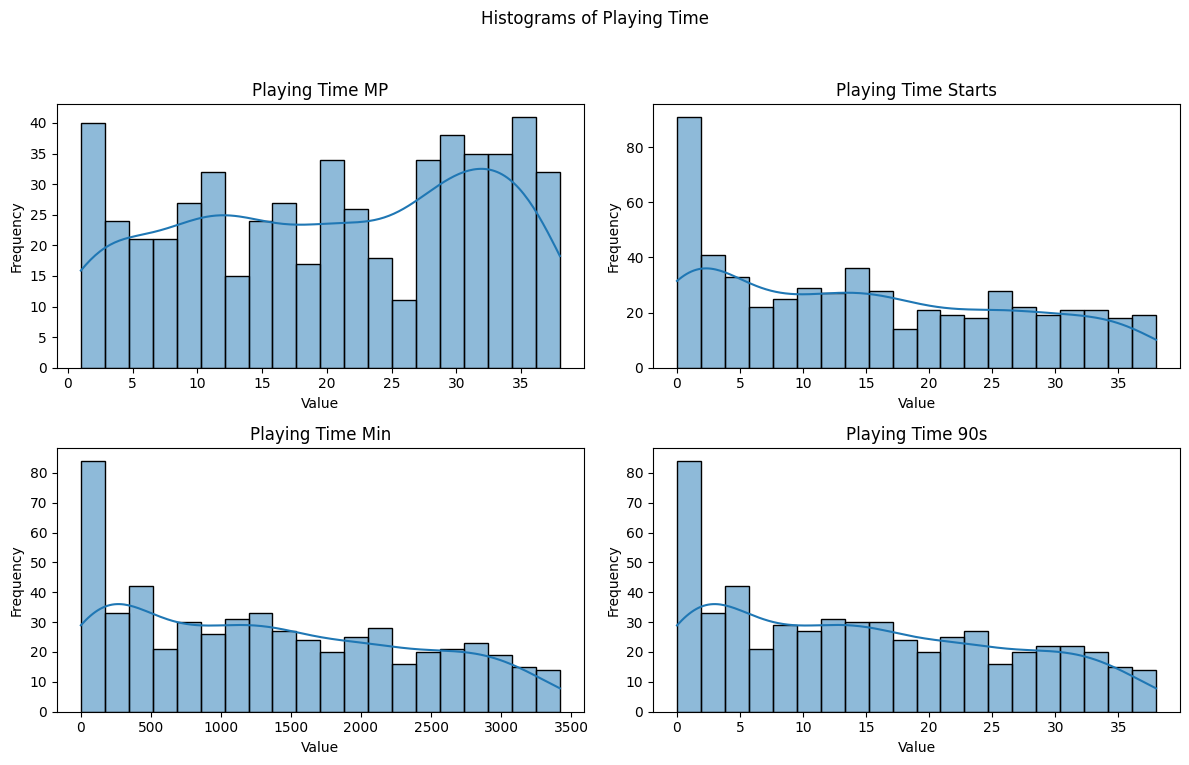

In [ ]:
# Select columns with "Playing Time" in their names
playing_time_columns = data.filter(like="Playing Time")

# Plot histograms using plt.subplot for each "Playing Time" column
num_columns = len(playing_time_columns.columns)
plt.figure(figsize=(12, 8))

# Loop through each column and create a subplot
for i, col in enumerate(playing_time_columns.columns, start=1):
    plt.subplot(2, 2, i)  # Adjust grid layout if needed
    sns.histplot(playing_time_columns[col].dropna(), bins=20, kde=True)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout
plt.suptitle("Histograms of Playing Time")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


<ipython-input-162-d95b1f4921b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_time_columns["Market Value_2023"] = data["Market Value_2023"]


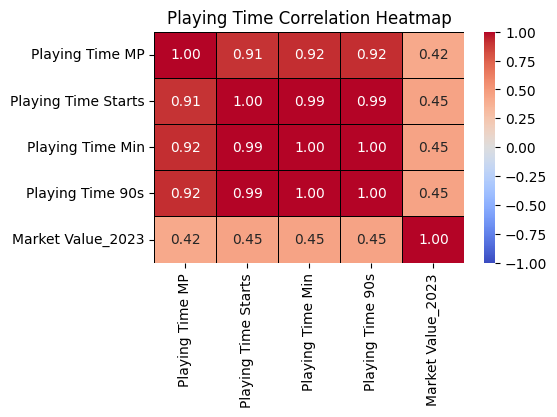

In [ ]:
# Add Market Value Column
playing_time_columns["Market Value_2023"] = data["Market Value_2023"]

# Select only numeric columns for the correlation matrix
correlation_matrix = playing_time_columns.corr()

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, linewidths=0.5, linecolor='black', vmin=-1, vmax=1,)
plt.title("Playing Time Correlation Heatmap")
plt.show()

<a id="expect"></a>

### Expected Stats

**Distribution**
The distribution of expected statistics is heavily right skewed with a long tail. This means that the majority of players have rather low values of expected goals and assists, while a few top performers have high values of expected stats. This corresponds with expectations, as different positions and different playing times likely influence the ability of players to achieve high levels of expected goals and assists. In particular, it matches the summary statistics [above](#gensum) that there are significant outliers in expected stats.

**Correlation**
The correlation heatmap shows that the expected stats are correlated. The expected goals & goals without penalties are expectedly highly correlated. However, it is noteworthy that expected assists and expected goals are slightly less correlated, meaning there are players that perform well in one and not as well in the other. The most correlation with market value appears to be a combination of expected goals and assists, which is the metric that best captures the (expected) impact of a player in a game.

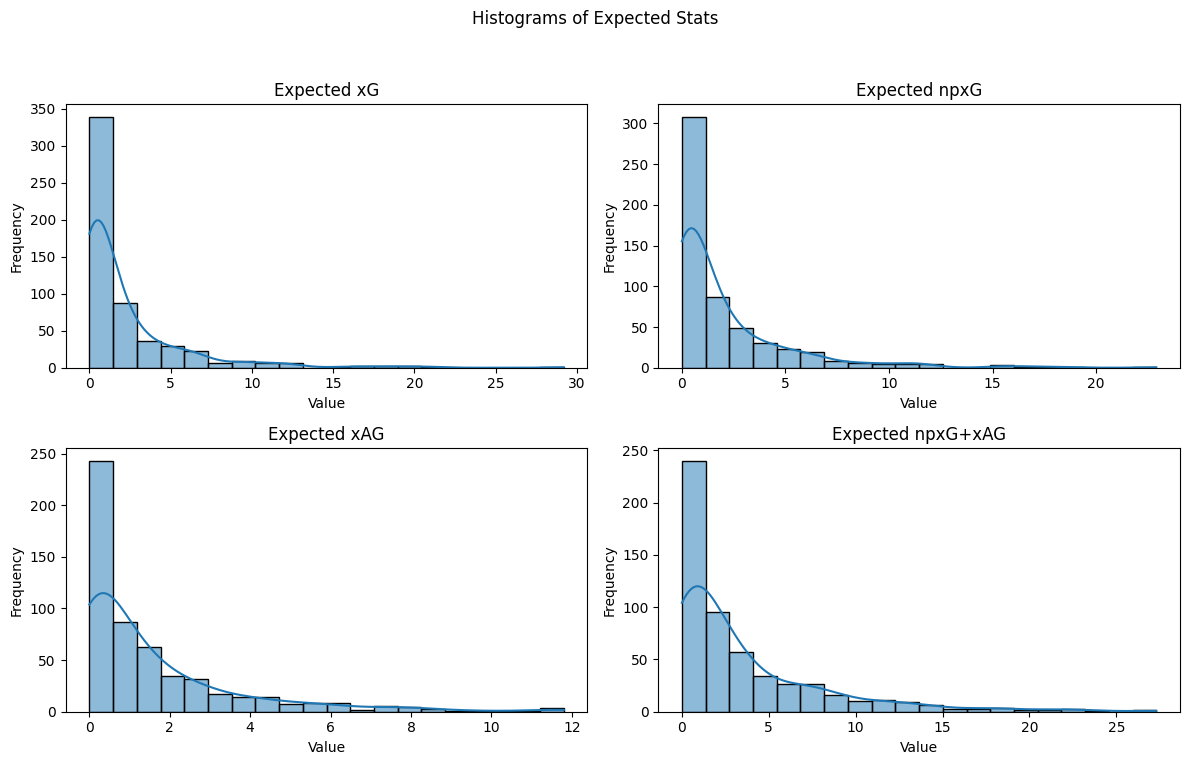

In [ ]:
# Select columns with "Expected" in their names
expect_columns = data.filter(like="Expected")

# Plot histograms using plt.subplot for each "Playing Time" column
num_columns = len(expect_columns.columns)
plt.figure(figsize=(12, 8))

# Loop through each column and create a subplot
for i, col in enumerate(expect_columns.columns, start=1):
    plt.subplot(2, 2, i)  # Adjust grid layout if needed
    sns.histplot(expect_columns[col].dropna(), bins=20, kde=True)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout
plt.suptitle("Histograms of Expected Stats")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<ipython-input-164-08f66f026585>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expect_columns["Market Value_2023"] = data["Market Value_2023"]


Text(0.5, 1.0, 'Expected Stats Correlation Heatmap')

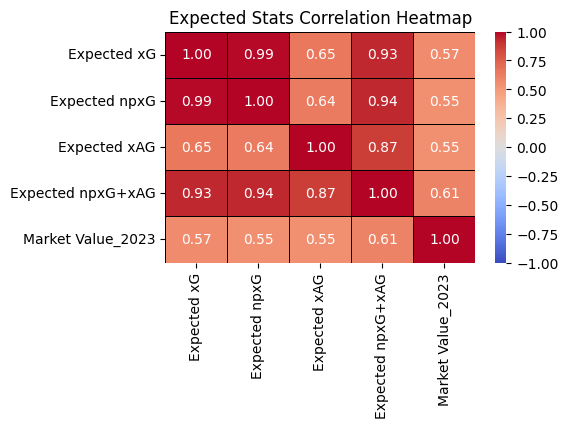

In [ ]:
# Add Market Value Column
expect_columns["Market Value_2023"] = data["Market Value_2023"]

# Select only numeric columns for the correlation matrix
correlation_matrix = expect_columns.corr()

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, linewidths=0.5, linecolor='black', vmin=-1, vmax=1,)
plt.title("Expected Stats Correlation Heatmap")

<a id="perform"></a>

### Performance Stats

**Distribution**
The distribution of performance stats shows a similar right skew with long tails as the expected stats above, where most players have a low number of goals, assists, yellow cards, etc., while there are some outliers.

**Correlation**
The correlation heatmap shows that "positive" statistics are correlated with each other (goals, assists, penalty shots) and "negative" statistics (yellow and red cards) are correlated with each other (although to a lesser degree). Some variables are extremely highly correlated, such as Penalties attempted and Penalties scored, as well as Goals and Goals without counting Penalties. These metrics could cause issues of multicolinearity. The variables associated with market value the most are Goals, Goals (without counting penalties), and goals & assists.

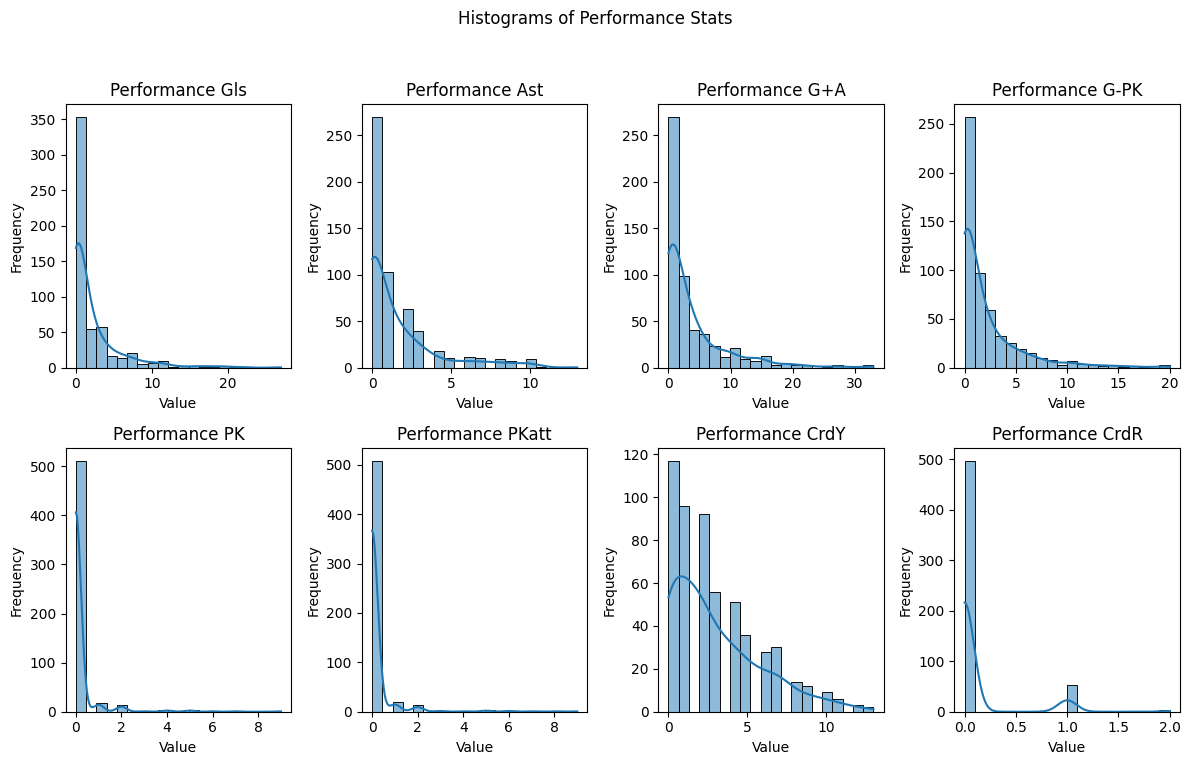

In [ ]:
# Select columns with "Performance" in their names
performance_columns = data.filter(like="Performance")

# Plot histograms using plt.subplot for each "Playing Time" column
num_columns = len(performance_columns.columns)
plt.figure(figsize=(12, 8))

# Loop through each column and create a subplot
for i, col in enumerate(performance_columns.columns, start=1):
    plt.subplot(2, 4, i)  # Adjust grid layout if needed
    sns.histplot(performance_columns[col].dropna(), bins=20, kde=True)  # Drop NaN for plotting
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout
plt.suptitle("Histograms of Performance Stats")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<ipython-input-166-eae53277be04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_columns["Market Value_2023"] = data["Market Value_2023"]


Text(0.5, 1.0, 'Performance Stats Correlation Heatmap')

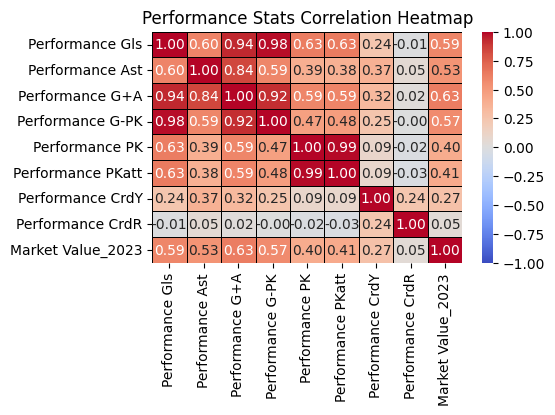

In [ ]:
# Add Market Value Column
performance_columns["Market Value_2023"] = data["Market Value_2023"]

# Select only numeric columns for the correlation matrix
correlation_matrix = performance_columns.corr()

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, linewidths=0.5, linecolor='black', vmin=-1, vmax=1,)
plt.title("Performance Stats Correlation Heatmap")

<a id="progress"></a>

### Progression Stats

**Distribution**
The distribution of progression stats shows a right skew. The majority of players do not have significantly high progression statistics, while a small number of players are outliers with high high levels of progressions.

**Correlation**
The correlation heatmap shows that dribling progressively and receiving progressive passes are heavily correlated. The market value is somewhat correlated with the progression stats of players (around 0.5).

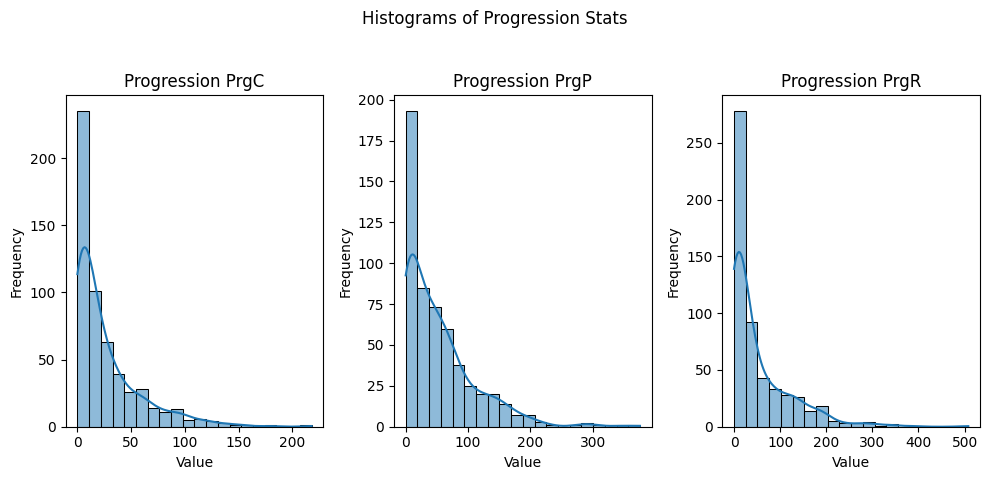

In [ ]:
# Select columns with "Per 90" in their names
progress_columns = data.filter(like="Progression")

# Plot histograms using plt.subplot for each "Playing Time" column
num_columns = len(progress_columns.columns)
plt.figure(figsize=(10, 5))

# Loop through each column and create a subplot
for i, col in enumerate(progress_columns.columns, start=1):
    plt.subplot(1, 3, i)  # Adjust grid layout if needed
    sns.histplot(progress_columns[col].dropna(), bins=20, kde=True)  # Drop NaN for plotting
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout
plt.suptitle("Histograms of Progression Stats")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<ipython-input-168-2f76c1eee589>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  progress_columns["Market Value_2023"] = data["Market Value_2023"]


Text(0.5, 1.0, 'Progression Stats Correlation Heatmap')

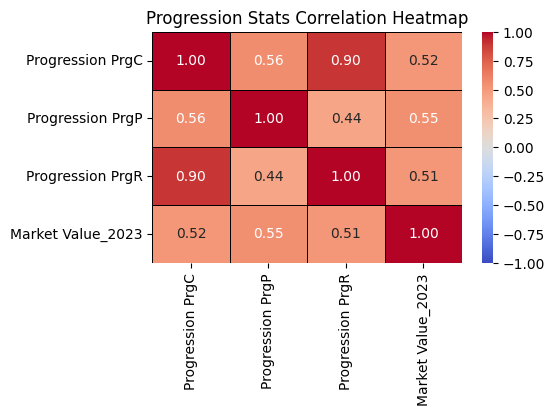

In [ ]:
# Add Market Value Column
progress_columns["Market Value_2023"] = data["Market Value_2023"]

# Select only numeric columns for the correlation matrix
correlation_matrix = progress_columns.corr()

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, linewidths=0.5, linecolor='black', vmin=-1, vmax=1,)
plt.title("Progression Stats Correlation Heatmap")

<a id="ninety"></a>

### Per 90 Stats

The Per 90 Minutes Performance Stats show similar trends as the Performance Trends above. Interestingly, the performance metrics above are more correlated with market value than the standardized performance metrics (per 90 minutes) in this section, (potentially) indicating that sheer volume is valued higher than performance per 90 minutes.

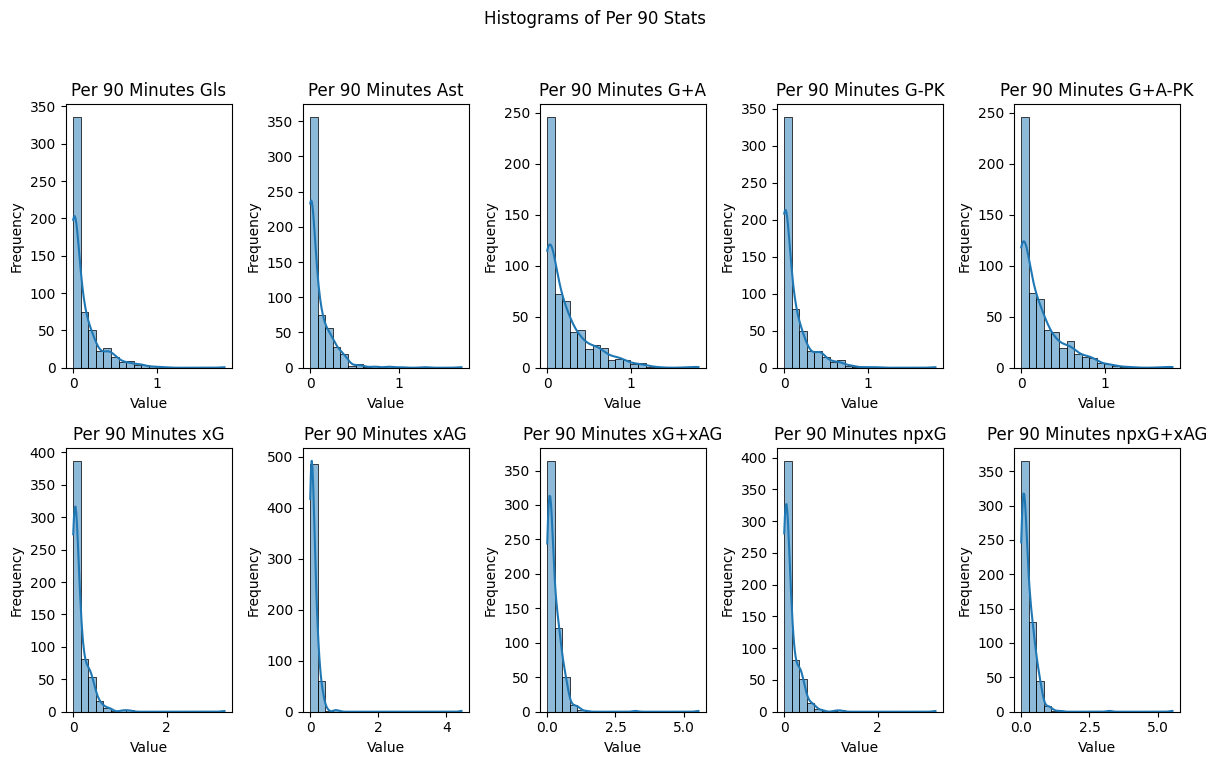

In [ ]:
# Select columns with "Per 90" in their names
per_90_columns = data.filter(like="Per 90")

# Plot histograms using plt.subplot for each "Playing Time" column
num_columns = len(per_90_columns.columns)
plt.figure(figsize=(12, 8))

# Loop through each column and create a subplot
for i, col in enumerate(per_90_columns.columns, start=1):
    plt.subplot(2, 5, i)  # Adjust grid layout if needed
    sns.histplot(per_90_columns[col].dropna(), bins=20, kde=True)  # Drop NaN for plotting
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout
plt.suptitle("Histograms of Per 90 Stats")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<ipython-input-170-6c45a0065f18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_90_columns["Market Value_2023"] = data["Market Value_2023"]


Text(0.5, 1.0, 'Per 90 Stats Correlation Heatmap')

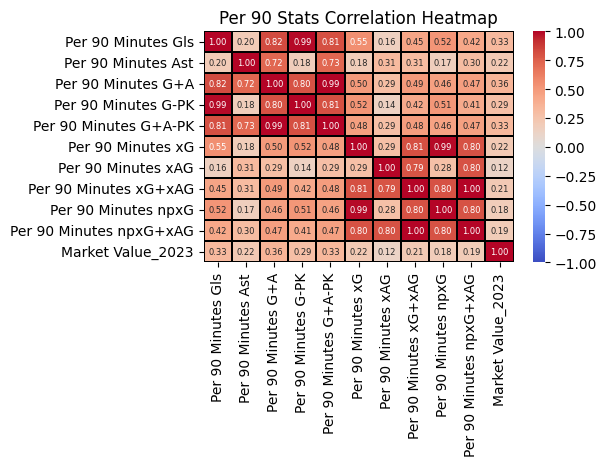

In [ ]:
# Add Market Value Column
per_90_columns["Market Value_2023"] = data["Market Value_2023"]

# Select only numeric columns for the correlation matrix
correlation_matrix = per_90_columns.corr()

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, linewidths=0.3, linecolor='black', vmin=-1, vmax=1, annot_kws={"size": 6})
plt.title("Per 90 Stats Correlation Heatmap")

<a id="mvalue"></a>

### Market Value

**Distribution:** The distribution of market value is right skewed, with a large number of players with low values. But there appear to be several significant outliers rather than a smooth tail on the high end of market values.

**Correlation:** The market value of at the beginning of the season is highly correlated with the market value at the end of the season.

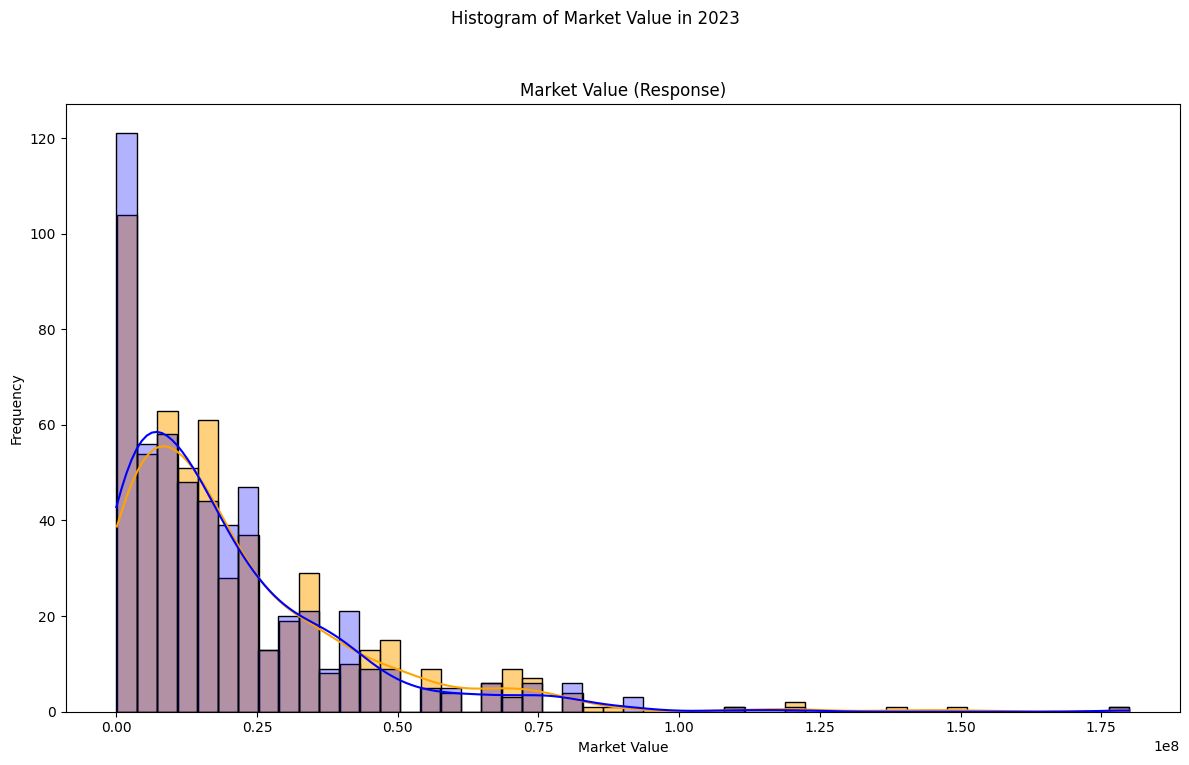

In [ ]:
# Plot histograms for each Market Value column
plt.figure(figsize=(12, 8))

# Loop through each column and create a subplot
sns.histplot(data['Market Value_2023'].dropna(), bins=50, kde=True, color='orange')  # Drop NaN for plotting
sns.histplot(data['Market Value_2022'].dropna(), bins=50, kde=True, color='blue', alpha=0.3)
plt.title('Market Value (Response)')
plt.xlabel('Market Value')
plt.ylabel('Frequency')

# Adjust layout
plt.suptitle("Histogram of Market Value in 2023")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Text(0.5, 1.0, 'Market Value Correlation Heatmap')

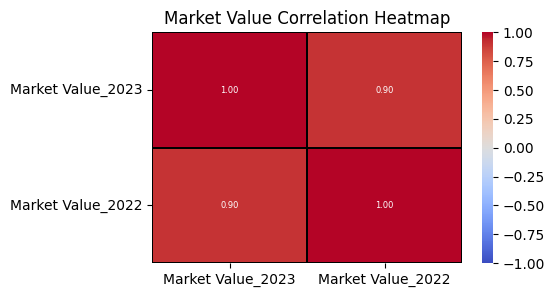

In [ ]:
# Select columns with "Per 90" in their names
mv_columns = data.filter(like="Market Value")

# Select only numeric columns for the correlation matrix
correlation_matrix = mv_columns.corr()

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, linewidths=0.3, linecolor='black', vmin=-1, vmax=1, annot_kws={"size": 6})
plt.title("Market Value Correlation Heatmap")

<a id="tpoints"></a>

### Team Points

**Distribution**: The distribution of team points shows a wide spread (between 16 and 90) with a slight concentration around 50 points.

**Correlation**: The market value is correlated with the team points to a similar degree as the other predictors (around 0.5).

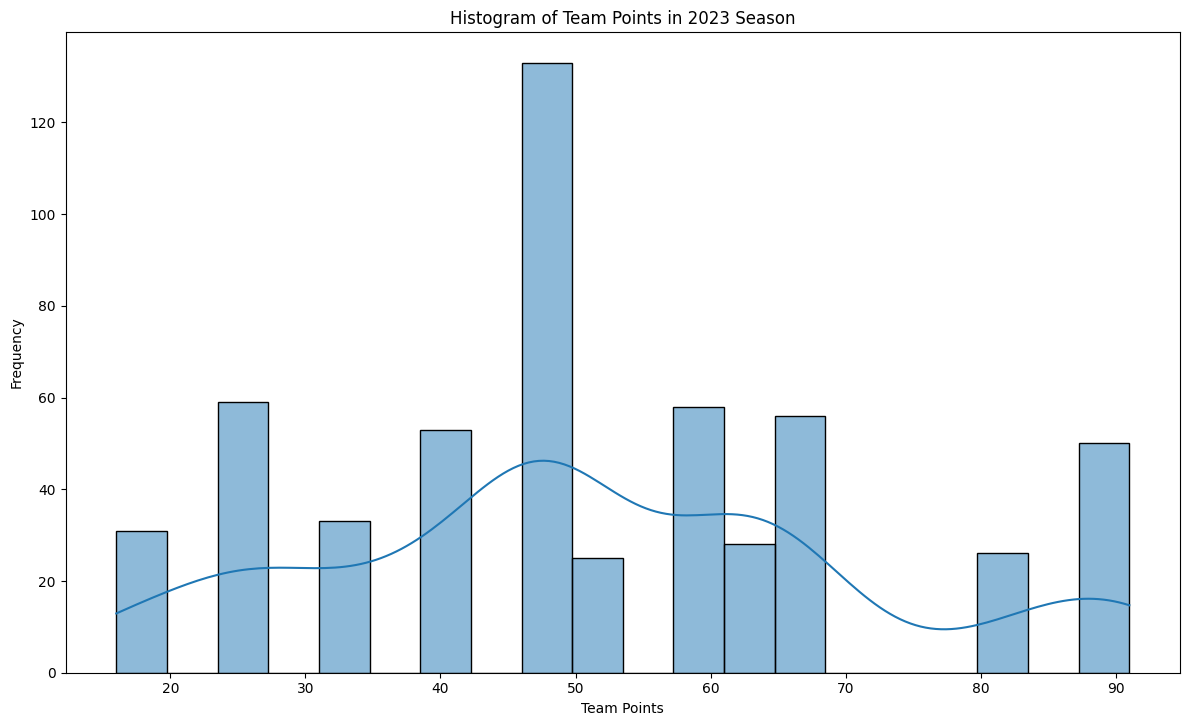

In [ ]:
# Plot histograms for each Market Value column
plt.figure(figsize=(12, 8))

# Loop through each column and create a subplot
sns.histplot(data['Team_Points'].dropna(), bins=20, kde=True)  # Drop NaN for plotting
plt.xlabel('Team Points')
plt.ylabel('Frequency')

# Adjust layout
plt.title("Histogram of Team Points in 2023 Season")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<ipython-input-174-6c3a5e227c80>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_columns["Market Value_2023"] = data["Market Value_2023"]


Text(0.5, 1.0, 'Per 90 Stats Correlation Heatmap')

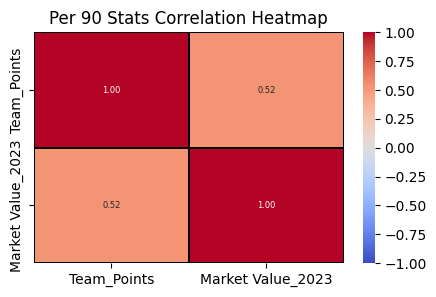

In [ ]:
# Add Market Value Column
tp_columns = data.filter(like='Team_Points')
tp_columns["Market Value_2023"] = data["Market Value_2023"]

# Select only numeric columns for the correlation matrix
correlation_matrix = tp_columns.corr()

# Plot the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, linewidths=0.3, linecolor='black', vmin=-1, vmax=1, annot_kws={"size": 6})
plt.title("Per 90 Stats Correlation Heatmap")

<a id="cor"></a>

### All Correlations

The total correlation map shows that market value is most correlated with performance stats like goals and assists, expected performance stats like expected goals and assists, and team points.

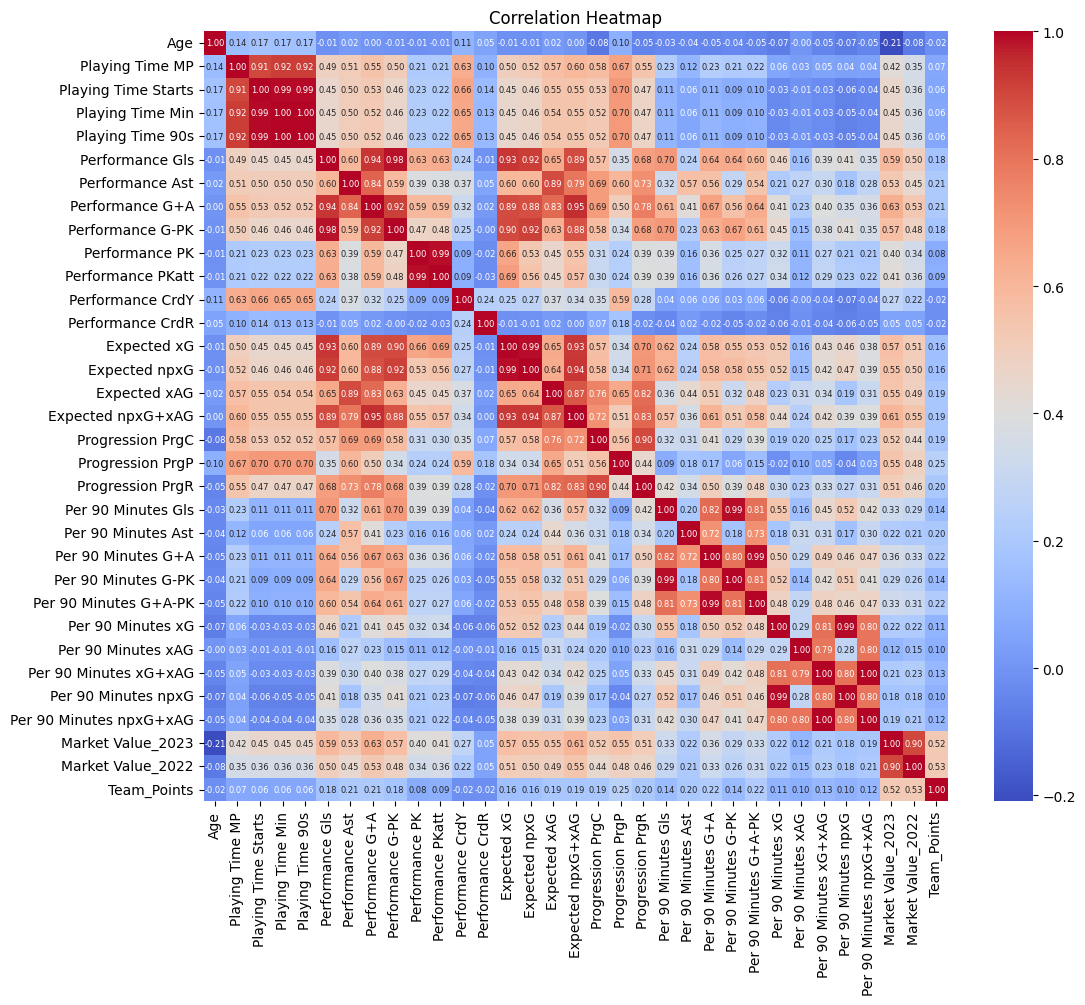

In [ ]:
# Select only numeric columns for the correlation matrix
numeric_df = data.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True, annot_kws={"size": 6})
plt.title("Correlation Heatmap")
plt.show()


<a id="initeda"></a>

## Initial EDA

- [**Minutes Threshold**](#minthresh)

- [**Positional Difference**](#posdiff)

<a id="minthresh"></a>

### Minutes Threshold

Our intiution suggested that players with high performance stats per 90 minutes would be undervalued at times, as they were particularly efficient but potentially did not receive the same amount of attention due to their limited playing time.

However, a look at the standardized (per 90 minutes) top goal scores renders a list of names that is surprising. It includes a mix of big names, such as attacking phenomenon Erling Haaland is only at number 4, and players that are completely unknown.

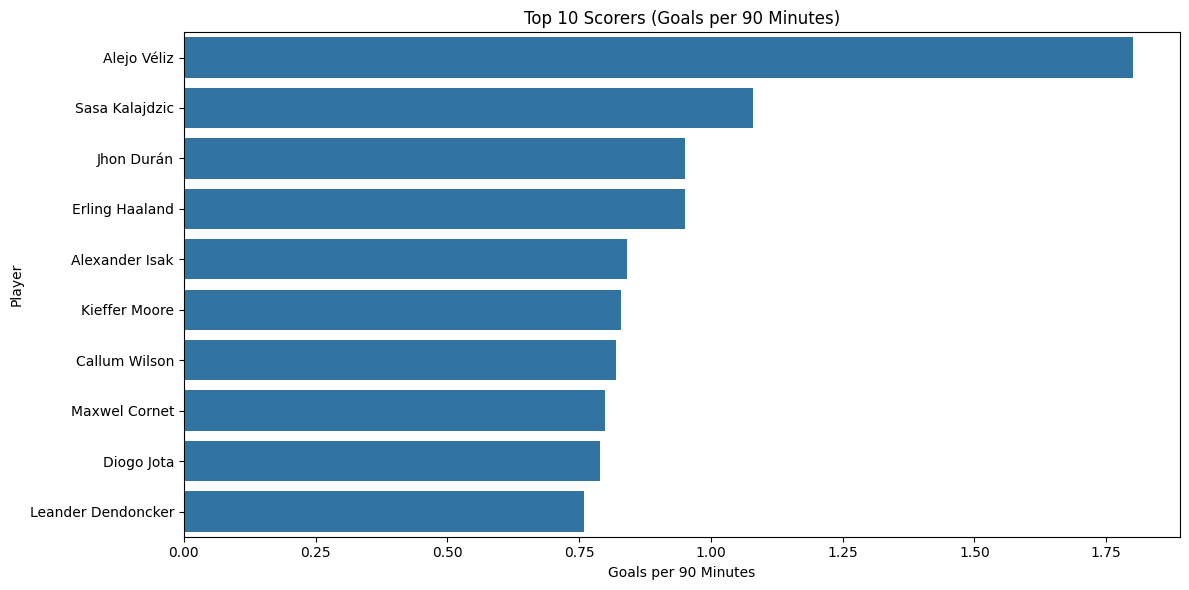

In [ ]:
# Filter out rows where 'Per 90 Minutes Gls' is NaN or 0
valid_scorers = data[data['Per 90 Minutes Gls'].notnull() & (data['Per 90 Minutes Gls'] > 0)]

# Get the top 10 scorers
top_scorers = valid_scorers.nlargest(10, 'Per 90 Minutes Gls')[['Player', 'Per 90 Minutes Gls', 'Playing Time MP']]

# Plot the top 10 scorers
plt.figure(figsize=(12, 6))
sns.barplot(x='Per 90 Minutes Gls', y='Player', data=top_scorers)
plt.title('Top 10 Scorers (Goals per 90 Minutes)')
plt.xlabel('Goals per 90 Minutes')
plt.ylabel('Player')
plt.tight_layout()

A closer look at the data reveals that some of the lesser known players listed above just haven't played many games. It seems we need a minimum threshold to capture the true best goalscorers. However, this could come at the cost of missing undervalued, emerging talent that has not had a significant chance to play.

In [ ]:
filtered_row = top_scorers.iloc[0]
name = filtered_row['Player']
games = filtered_row['Playing Time MP']
print(f'{name}] has played {games} matches this season')

Alejo Véliz] has played 8 matches this season


A threshold of 900 minutes played renders a list of more familiar names.

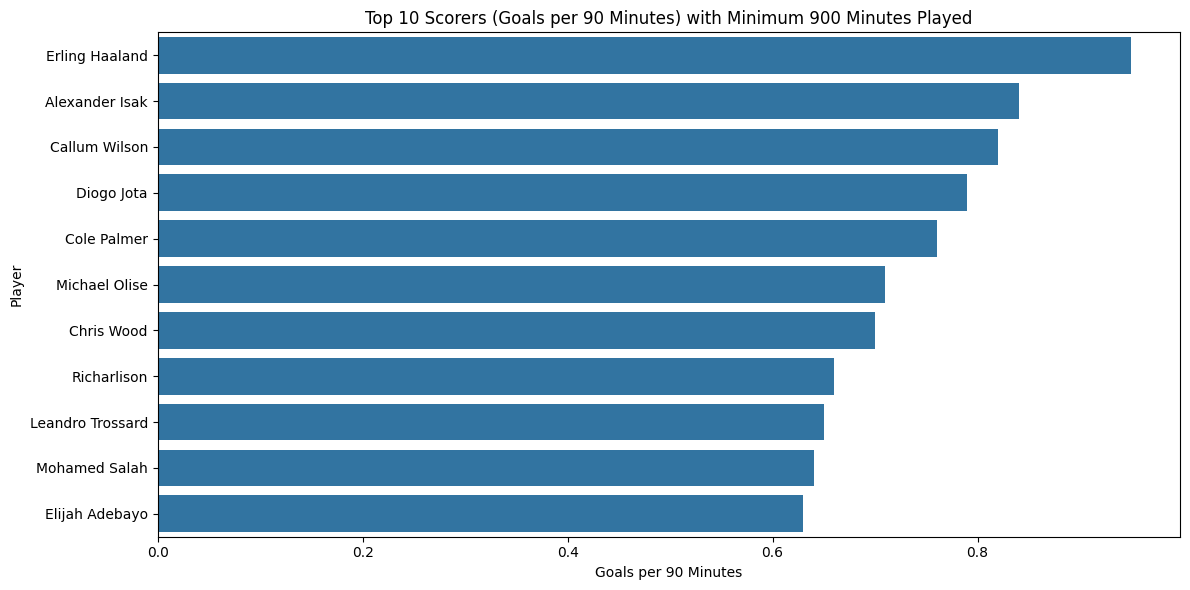

In [ ]:
# Filter players with at least 900 minutes played and valid 'Per 90 Minutes Gls'
valid_scorers = data[(data['Per 90 Minutes Gls'].notnull()) &
                   (data['Per 90 Minutes Gls'] > 0) &
                   (data['Playing Time Min'] >= 900)]

# Get the top 10 scorers
top_scorers = valid_scorers.nlargest(11, 'Per 90 Minutes Gls')[['Player', 'Per 90 Minutes Gls']]

# Plot the top 10 scorers
plt.figure(figsize=(12, 6))
sns.barplot(x='Per 90 Minutes Gls', y='Player', data=top_scorers)
plt.title('Top 10 Scorers (Goals per 90 Minutes) with Minimum 900 Minutes Played')
plt.xlabel('Goals per 90 Minutes')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

The tradeoff between valuing standardized performances vs total performances is solved by looking at the response value (Market Value_2023). As seen above, the lower correlation of the Per 90 stats than the performance stats suggests that total performance is more predictive than efficiency (performance per same number of minutes) of market value. As a result, we will drop Per 90 stats (given their collinearity with Performance stats).

<a id="posdiff"></a>

### Positional Differences

In [ ]:
# Create a consistent color palette
unique_positions = data['Position_Group'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_positions))
color_dict = dict(zip(unique_positions, palette))
# Colors for plots
colors = [color_dict[group] for group in unique_positions]

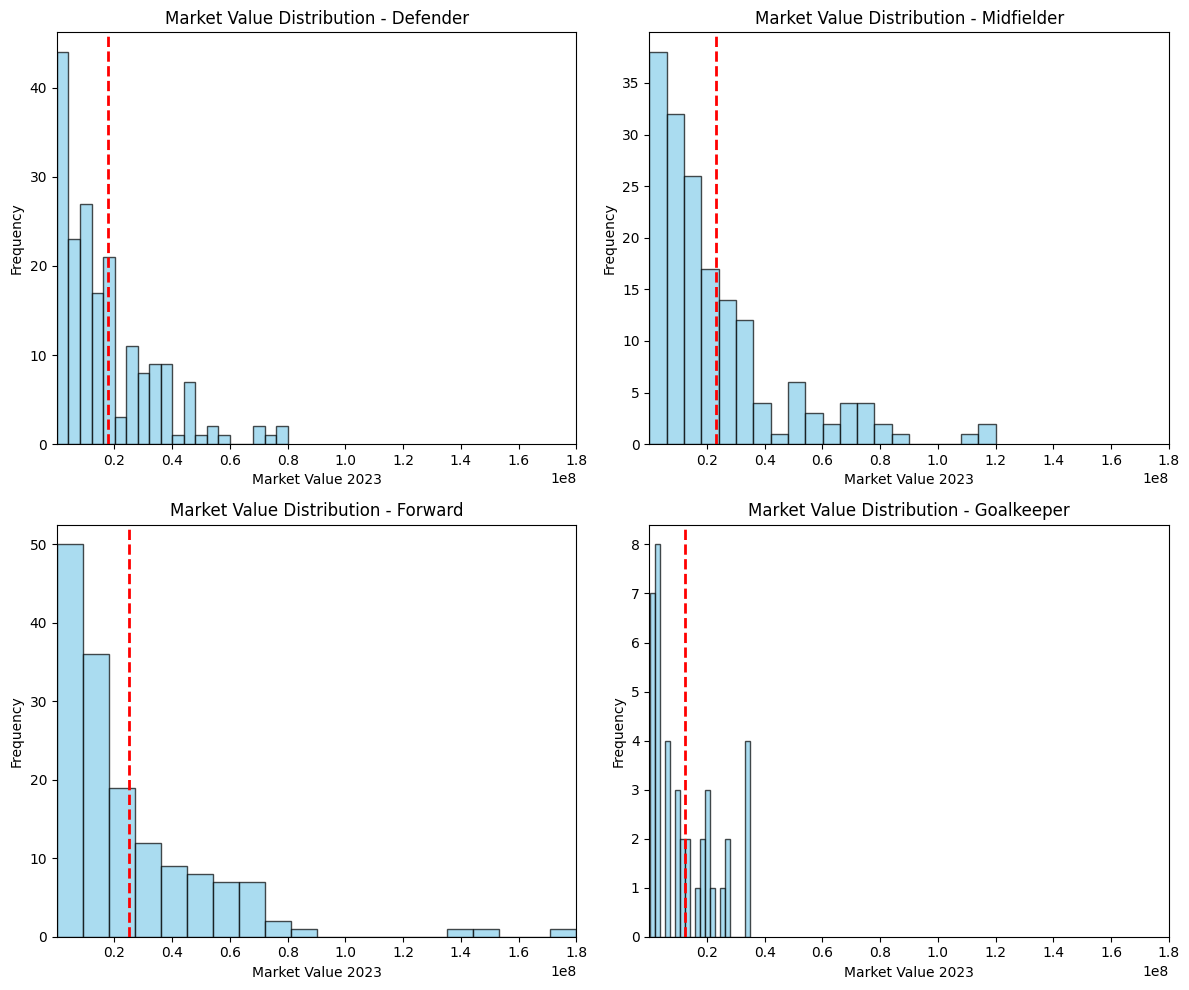

In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten axes to iterate easily

# Calculate global x-axis limits for consistency
min_x = data['Market Value_2023'].min()
max_x = data['Market Value_2023'].max()

# Grouped mean statistics
average_stats = data.groupby('Position_Group').agg({
    'Market Value_2023': 'mean'
}).reset_index()

# Extract Position Groups and Means
position_groups = average_stats['Position_Group']
means = average_stats['Market Value_2023']

# Plot individual histograms for each positional group
for i, group in enumerate(unique_positions):
    group_data = data[data['Position_Group'] == group]

    # Plot histogram on its respective subplot
    axes[i].hist(group_data['Market Value_2023'], bins=20, alpha=0.7, edgecolor='black', color='skyblue')
    axes[i].axvline(group_data['Market Value_2023'].mean(), color='red', linestyle='--', linewidth=2, label='label')
    # for mean, group in zip(means, position_groups):
    #     axes[i].axvline(x=mean, color='red', linestyle='--', linewidth=2, label=f'{group} Mean')
    axes[i].set_title(f"Market Value Distribution - {group}")
    axes[i].set_xlabel("Market Value 2023")
    axes[i].set_ylabel("Frequency")

    # Set standardized x-axis limits
    axes[i].set_xlim(min_x, max_x)

# Hide any unused subplots (if less than 4 groups)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

**Market Value**: First, we looked at the distributions of market value across positions. We did not want to build a model that would highlight all defenders as undervalued, simply because defenders were (on average) valued lower than forwards. In other words, we sought to understand whether players across positions could be considered an 'apples' to 'apples' comparison.

 *The different distributions of market values across positions questions the decision to build a single model. Instead, we could consider building a different model for each position and finding the most undervalued players at each position*  

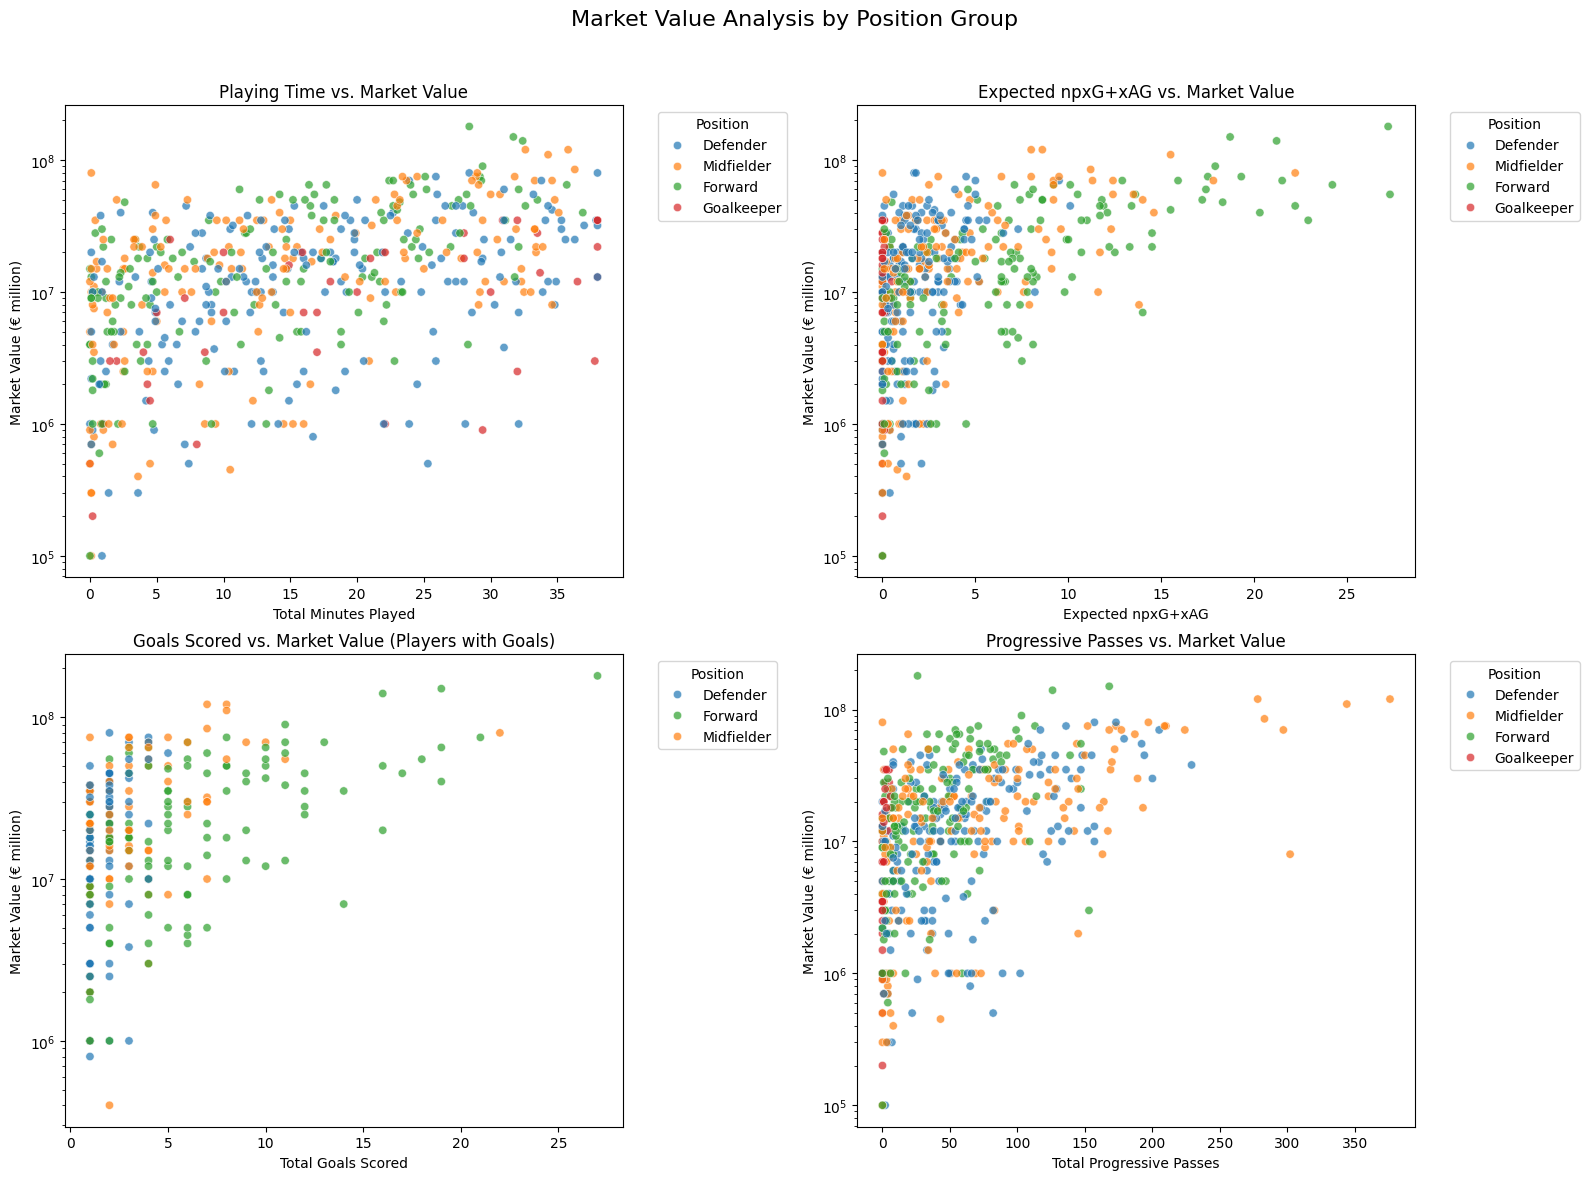

In [ ]:
# Prepare the data: Filter players with goals
scored_goals_data = data[data['Performance Gls'] > 0]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Market Value Analysis by Position Group', fontsize=16)

# Scatter Plot 1: Playing Time vs Market Value
sns.scatterplot(
    x='Playing Time 90s',
    y='Market Value_2023',
    hue='Position_Group',
    data=data,
    alpha=0.7,
    palette=color_dict,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Playing Time vs. Market Value')
axes[0, 0].set_xlabel('Total Minutes Played')
axes[0, 0].set_ylabel('Market Value (€ million)')
axes[0, 0].set_yscale('log')

# Scatter Plot 2: Expected Stats vs Market Value
sns.scatterplot(
    x='Expected npxG+xAG',
    y='Market Value_2023',
    hue='Position_Group',
    data=data,
    alpha=0.7,
    palette=color_dict,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Expected npxG+xAG vs. Market Value')
axes[0, 1].set_xlabel('Expected npxG+xAG')
axes[0, 1].set_ylabel('Market Value (€ million)')
axes[0, 1].set_yscale('log')

# Scatter Plot 3: Goals Scored vs Market Value
sns.scatterplot(
    x='Performance Gls',
    y='Market Value_2023',
    hue='Position_Group',
    data=scored_goals_data,
    alpha=0.7,
    palette=color_dict,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Goals Scored vs. Market Value (Players with Goals)')
axes[1, 0].set_xlabel('Total Goals Scored')
axes[1, 0].set_ylabel('Market Value (€ million)')
axes[1, 0].set_yscale('log')

# Scatter Plot 4: Progressive Passes vs Market Value
sns.scatterplot(
    x='Progression PrgP',
    y='Market Value_2023',
    hue='Position_Group',
    data=data,
    alpha=0.7,
    palette=color_dict,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Progressive Passes vs. Market Value')
axes[1, 1].set_xlabel('Total Progressive Passes')
axes[1, 1].set_ylabel('Market Value (€ million)')
axes[1, 1].set_yscale('log')

# Adjust legend, layout, and spacing
for ax in axes.flatten():
    ax.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust for suptitle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-183-1cc81ffbd904>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-183-1cc81ffbd904>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-183-1cc81ffbd904>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-183-1cc81ffbd904>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-183-1cc81ffbd904>:31: FutureWarning: 

Passin

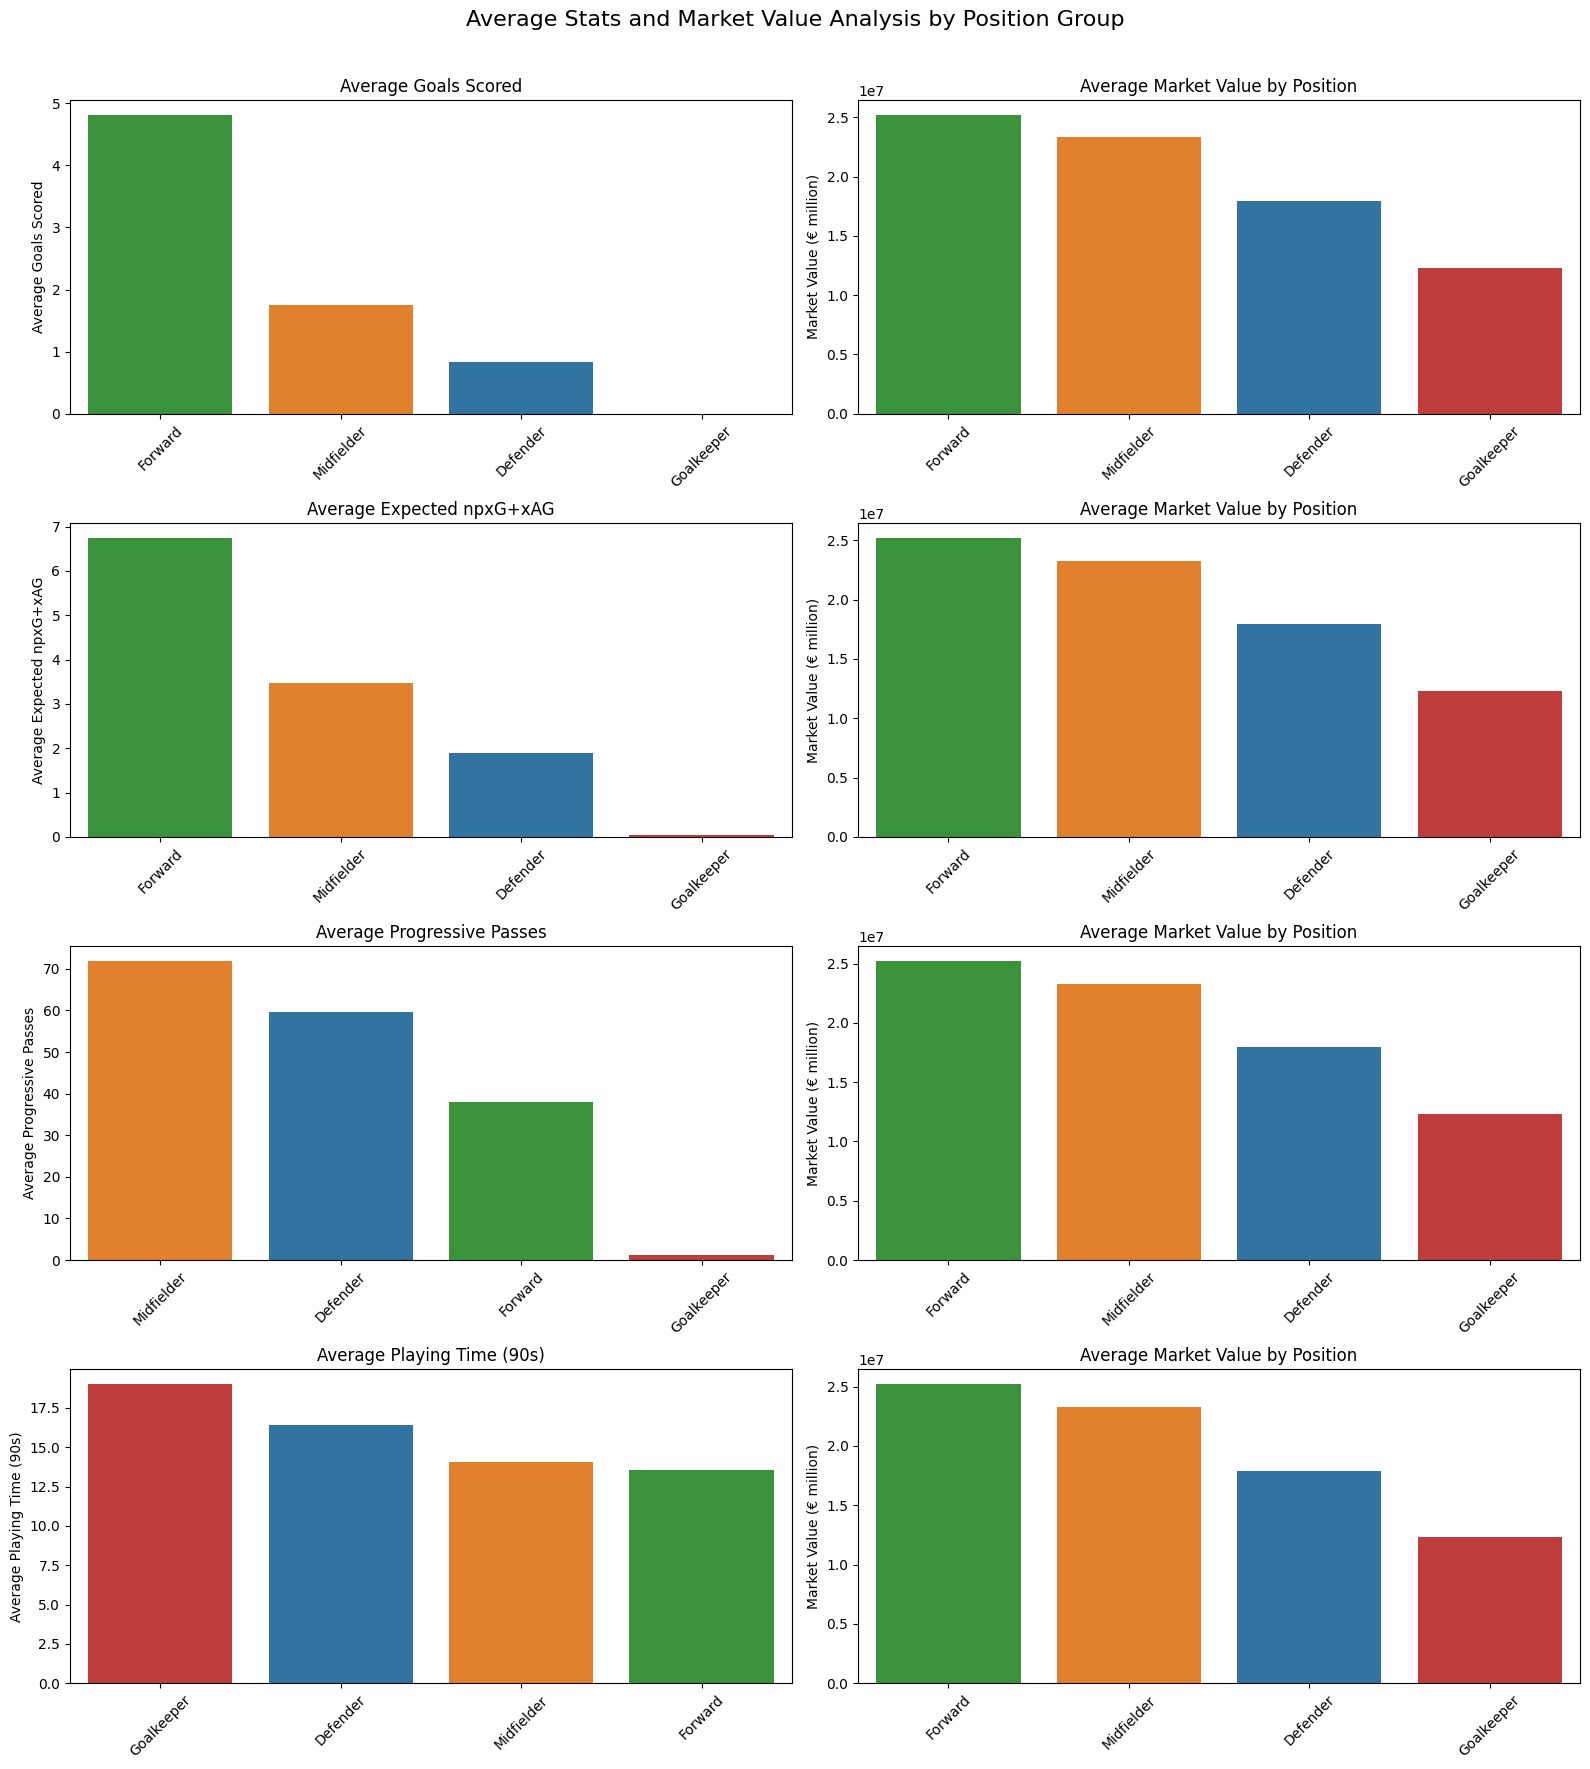

In [ ]:
# Aggregate data for average metrics
average_stats = data.groupby('Position_Group').agg({
    'Performance Gls': 'mean',
    'Expected npxG+xAG': 'mean',
    'Progression PrgP': 'mean',
    'Playing Time 90s': 'mean',
    'Market Value_2023': 'mean'
}).reset_index()

# Sort the data for Market Value
average_stats_market_sorted = average_stats.sort_values(by='Market Value_2023', ascending=False)

# Metrics to Plot
metrics = [
    ('Performance Gls', 'Average Goals Scored'),
    ('Expected npxG+xAG', 'Average Expected npxG+xAG'),
    ('Progression PrgP', 'Average Progressive Passes'),
    ('Playing Time 90s', 'Average Playing Time (90s)')
]

# Create 2x4 grid of plots
fig, axes = plt.subplots(4, 2, figsize=(16, 18))  # 4 rows, 2 columns
fig.suptitle('Average Stats and Market Value Analysis by Position Group', fontsize=16)

# Flatten axes for easy access
axes = axes.flatten()

# Loop to create bar charts for stats (Left Column)
for i, (metric, title) in enumerate(metrics):
    # Left Column: Average Stat
    sns.barplot(
        x='Position_Group',
        y=metric,
        data=average_stats.sort_values(by=metric, ascending=False),
        ax=axes[2 * i],
        palette=color_dict
    )
    axes[2 * i].set_title(title)
    axes[2 * i].set_ylabel(title)
    axes[2 * i].set_xlabel('')
    axes[2 * i].tick_params(axis='x', rotation=45)

    # Right Column: Average Market Value
    sns.barplot(
        x='Position_Group',
        y='Market Value_2023',
        data=average_stats_market_sorted,
        ax=axes[2 * i + 1],
        palette=color_dict
    )
    axes[2 * i + 1].set_title('Average Market Value by Position')
    axes[2 * i + 1].set_ylabel('Market Value (€ million)')
    axes[2 * i + 1].set_xlabel('')
    axes[2 * i + 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Space for the suptitle


The following conclusions are drawn based on the spread of points for each position across all four scatter plots and the differences across bar charts.

For the scatter plot, looking at the predictor and its relationship to market value provides insight which statistics matter most for a position.

For the bar chart, ranking the average value of a predictor and comparing it to the ranking of market value shows disparities in how each metric contributes to market value.

The relationship between the market value and some of the strongest correlates across different categories of performance statistics (playing time, performance stats, expected stats, progressing stats) shows clear differences across differences.

**For forwards**, the goals and expected non-penalty goals and assisted goals are important statistics for market value.

**For midfielders**, expected non-penalty goals and assisted goals and progressive passes are important to predict market value.

**For defenders**, minutes played and progressive passes play an important role in determining market value.

**For goalkeeprs**, minutes played appears critical to determine market value.

*As a result, we will build a separate models for each position, both to capture the differing importance of the performance statistics and to avoid comparing 'apples' and 'oranges' by comparing player positions with different distributions of market value.*

<a id="basemodels"></a>
## Base Models

- [Feature Selection](#featselect)

- [Linear Regression](#linregmodel)

- [Decision Tree](#dtmodel)

- [Initial Results](#initres)

In [ ]:
from IPython.display import Image, display

display(Image("/Model.jpeg"))

FileNotFoundError: No such file or directory: '/Model.jpeg'

FileNotFoundError: No such file or directory: '/Model.jpeg'

<IPython.core.display.Image object>

<a id="featselect"></a>

### Feature Selection

In [ ]:
# Select features and target for the model
drop_features = [
    'Per 90 Minutes Gls', 'Per 90 Minutes Ast', 'Per 90 Minutes G+A',
    'Per 90 Minutes G-PK', 'Per 90 Minutes G+A-PK', 'Per 90 Minutes xG',
    'Per 90 Minutes xAG', 'Per 90 Minutes xG+xAG', 'Per 90 Minutes npxG',
    'Per 90 Minutes npxG+xAG', 'Player', 'Nation', 'Squad', 'Position',
    'Market Value_2023', 'Position_Group'
]

target = 'Market Value_2023'

X = data.drop(columns=drop_features)
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# Initialize results dictionary to store metrics for both models
results = {}

The features we have selected are due to the correlations we found when doing intial EDA. As mentioned above, we dropped the Per_90 stats due to their collinearity with Performance Stats and their lower correlation.

We include the Market Value of 2022 because we want to build a model that does not simply rely on the past season to predict player value. Instead of including historical player performance data, we rely on the previous year's market value to capture the discrepancies of player valuation in the past.

We exclude player name, nation, squad, positional group, and position.

**Player Name**: The player name functions as our index and is not a predictor.

**Nation**: When we includ the nationality of the players in the model, the model performance decreases, while the nationalities are not found to be important predictors. This fits nicely into our desired focus on performance metrics rather than contingencies outside of the player's control, such as country of origin.

**Squad**: We exclude squad because it is perfectly collinear with the Team_Points variable that captures the total earned points of a team at the end of the season.

**Positional Group**: We exclude the positional group, considering we are building a separate model for each positional group.

**Position**: We exclude the position of the player because we found that it does not significantly increase model performance and it does not provide additional information for our performance score, as it is not contingent on player performance.

<a id="linregmodel"></a>

### Linear Regression Model

In [ ]:
# Fit linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
# predictions with linear regression
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression model
results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_linear),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_linear)),
    'R^2': r2_score(y_test, y_pred_linear)
}

#### Assumptions of a Linear Regression

**Linearity**

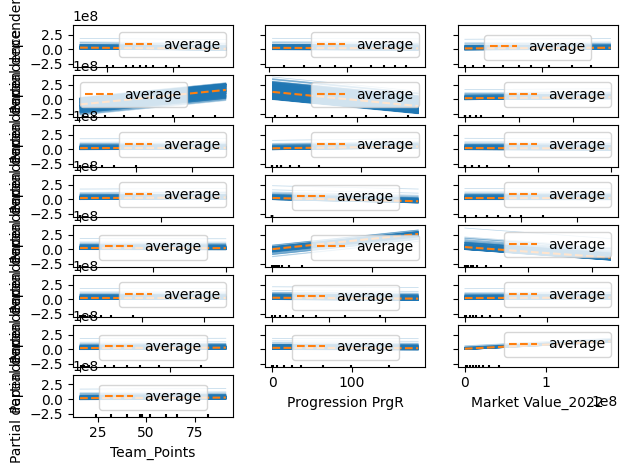

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

features = X_train.columns

# Plot partial dependence for all features
PartialDependenceDisplay.from_estimator(linear_model, X_train, features, kind='both', grid_resolution=100)
plt.tight_layout()
plt.show()

**Homoscedasicity**

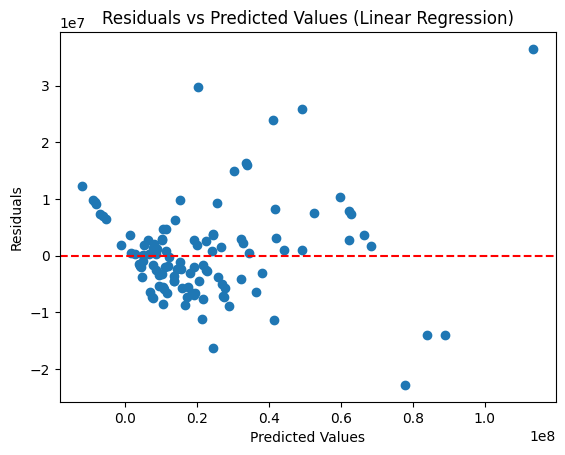

In [ ]:
# Residuals for Linear Regression
residuals_lr = y_test - y_pred_linear
plt.scatter(y_pred_linear, residuals_lr)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Linear Regression)')
plt.show()

**Normality of Residuals**

Text(0.5, 0, 'Residuals')

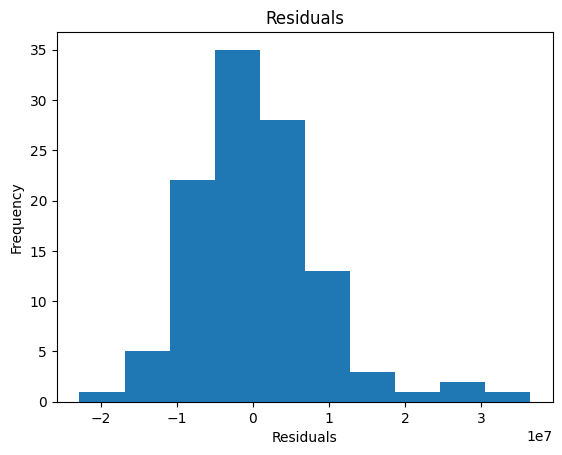

In [ ]:
# Normality of Residuals
plt.hist(residuals_lr);
plt.title('Residuals');
plt.ylabel('Frequency')
plt.xlabel('Residuals')

Our data appears to violate some of the assumptions of a linear regression model.

**Linearity**: The data indicates clear trends of linearity across most features.

**Homoscedasticity**: The assumption of homoscedasticity appears to be violated. The residual plot shows that the variance of the residuals grows as the magnitude of the predicted values increases.

**Normality of Residuals**: The data also seems to violate the assumption of normally distributed residuals. A closer look at the histogram of the residuals shows that it is almost normally distributed, but it has a tail to the right.

*As a result, a simple linear regression model may not appear like the best model to predict the market value of players.*

<a id="dtmodel"></a>

### Decision Tree Model

In [ ]:
# Model 2: Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(random_state=109, max_depth=10)
decision_tree_model.fit(X_train, y_train)
# Predict with Decision Tree
y_pred_tree = decision_tree_model.predict(X_test)

# Evaluate Decision Tree model
results['Decision Tree'] = {
    'MAE': mean_absolute_error(y_test, y_pred_tree),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_tree)),
    'R^2': r2_score(y_test, y_pred_tree)
}

<a id="initres"></a>
### Initial Results

In [ ]:
# Print results
results_df = pd.DataFrame(results).T
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model', 'MAE': 'Mean Absolute Error', 'RMSE': 'Root Mean Squared Error', 'R^2': 'R-Squared'}, inplace=True)

print(results_df)

               Model  Mean Absolute Error  Root Mean Squared Error  R-Squared
0  Linear Regression         6.029194e+06             8.606620e+06   0.871211
1      Decision Tree         6.589470e+06             1.111342e+07   0.785263


Looking at the performance results through MAE, RMSE, and R-Squared values, we can start to see significant differences in their predictive accuracy. The Linear Regression demonstrates superior performance, with a lower Mean Absolute Error of approximately 5.76 million and a lower Root Mean Squared Error of 8.89 million, indicating more precise and consistent predictions. Additionally, its R^2 value of 0.8808 suggests that it explains 88.08% of the variance in the data, making it a well-fitting model for this task. In contrast, the Decision Tree model exhibits a higher MAE of 7.84 million and a substantially higher RMSE of 11.89 million, signaling less accurate predictions. Its R^2 value of 0.78659 further reflects that it explains only 78.66% of the variance.

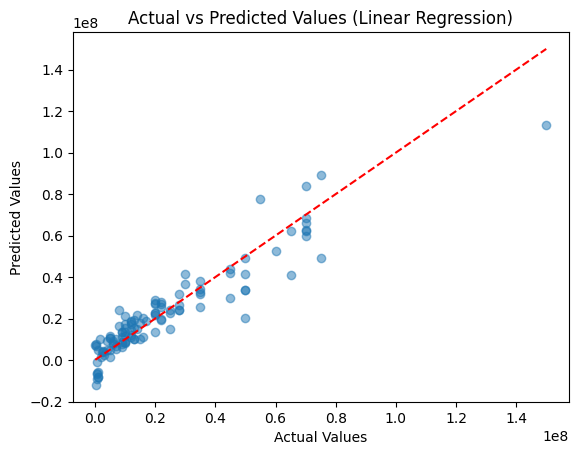

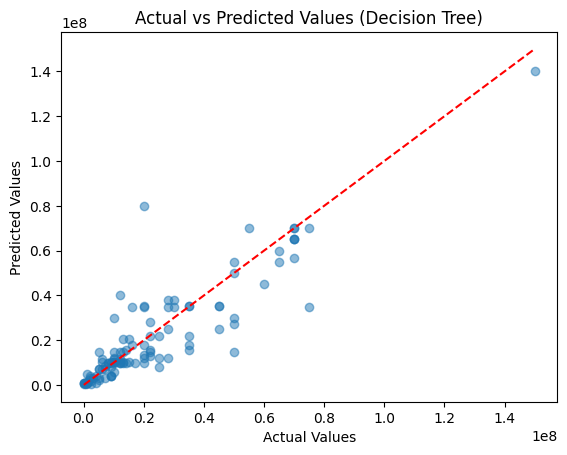

In [ ]:
# Plot for Linear Regression
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.show()

# Plot for Decision Tree
plt.scatter(y_test, y_pred_tree, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Decision Tree)')
plt.show()

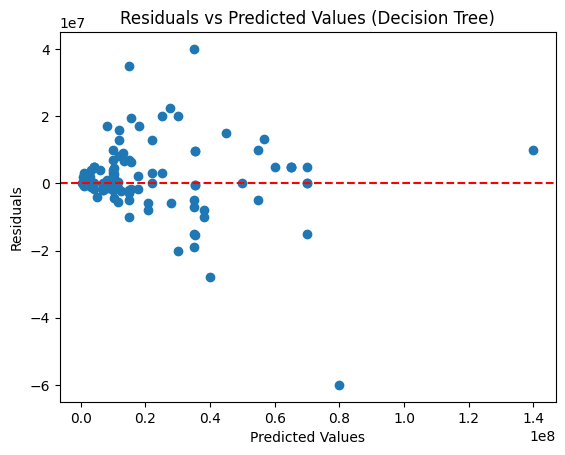

In [ ]:
# Residuals for Decision Tree
residuals_tree = y_test - y_pred_tree
plt.scatter(y_pred_tree, residuals_tree)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Decision Tree)')
plt.show()

Even though the current results suggest that Linear Regression outperforms the Decision Tree model in terms of predictive accuracy and explanatory power, the data appears to violate the assumptions of a linear regression model. As a result, a decision tree with aggregation methods is deemed more suitable for our modeling project. We believe that further refinements through things like more data preprocessing within our pipeline could significantly alter the performance of the model.

With the Decision Tree, we can incorporate hyperparameter tuning which would invlove adjusting the tree's maximum depth, the minimum number of samples per split, or leaf size, all of which could improve its generalization and reduce overfitting. Additionally, altering the current feature selection could help the model perform better with the data.

<a id="model_select"></a>
## Model Pipeline

- [Model Training](#model_train)

- [Model Selection](#model_comp)

- [Feature Importance](#feat_imp)

- [Feature Engineering](#feat_eng)

- [Performance Buckets](#perf_bucks)

- [Player Valuation](#player_val)

<a id="model_train"></a>
### Model Training

**Single Decision Tree**

In [ ]:
# Define positional groups
positional_groups = data['Position_Group'].unique()

# Hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Store models and results
models = {}
results = {}

# Loop through each positional group
for group in positional_groups:
    print(f"Training Decision Tree for {group} group...")

    group_data = data[data['Position_Group'] == group]
    if group_data.empty:
        print(f"No data for group {group}. Skipping...")
        continue

    # Split features and target
    X = group_data.drop(columns=drop_features)  # Features
    y = group_data[target]  # Target

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

    # Initialize the model
    tree = DecisionTreeRegressor(random_state=109)

    cv = KFold(n_splits=5, shuffle=True, random_state=109)

    grid_search = GridSearchCV(estimator=tree, param_grid=param_grid,
                               cv=cv, scoring='neg_mean_squared_error', verbose=0)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Best model from GridSearch
    best_model = grid_search.best_estimator_
    models[group] = best_model

    # Test the model
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    # Evaluate Decision Tree model
    results[group] = {
    'Best Hyperparameters': grid_search.best_params_,
    'MAE': mean_absolute_error(y_test, y_pred_test),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'R^2': r2_score(y_test, y_pred_test)
}

# Display results
print("\nSummary of Results:")
for group, result in results.items():
    print(f"{group}: {result}")

Training Decision Tree for Defender group...
Training Decision Tree for Midfielder group...
Training Decision Tree for Forward group...
Training Decision Tree for Goalkeeper group...

Summary of Results:
Defender: {'Best Hyperparameters': {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}, 'MAE': 3940091.764101052, 'Train RMSE': 5449530.140470031, 'Test RMSE': 5530743.424591461, 'R^2': 0.8698910785250908}
Midfielder: {'Best Hyperparameters': {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}, 'MAE': 7708204.4988380745, 'Train RMSE': 6893981.954520646, 'Test RMSE': 11211322.86471684, 'R^2': 0.7641120365882025}
Forward: {'Best Hyperparameters': {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}, 'MAE': 7366129.032258064, 'Train RMSE': 3766128.8197913347, 'Test RMSE': 10456245.668341123, 'R^2': 0.6971880533892318}
Goalkeeper: {'Best Hyperparameters': {'max_depth': 10, 'max_features'

The initial training of a single decision tree shows promising performance on the test set. Using cross validation and the GridSearchCV function to choose the hyperparameters, we are able to train four models (one per positional group), three of which perform well on unseen data. The only concern remains the performance of the goalkeeper model, as it relies on a particularly small training set (32 data points), and thus performs significantly worse on unseen data. However, a quick  look comparing the Train and Test RSME hints at the reasons for its poor performance: overfitting. Thus, we consider using bagging to reduce the variance of our models.

**Bagging**

In [ ]:
# Hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Store results for Bagging and the models themselves
results_bagging = {}
bagging_models = {}  # To store the trained Bagging models

# Loop through each positional group
for group in positional_groups:
    print(f"Training models for {group} group...")

    group_data = data[data['Position_Group'] == group]
    if group_data.empty:
        print(f"No data for group {group}. Skipping...")
        continue

    # Features and target
    X = group_data.drop(columns=drop_features, errors='ignore')  # Features
    y = group_data[target]  # Target

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

    ## Bagging Regressor
    bagging = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=109),
                               n_estimators=50, n_jobs=-1, random_state=109)
    bagging.fit(X_train, y_train)

    # Store the trained Bagging model
    bagging_models[group] = bagging

    # Predictions for Bagging
    y_pred_train_bagging = bagging.predict(X_train)
    y_pred_test_bagging = bagging.predict(X_test)

    # Store Bagging results
    results_bagging[group] = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_bagging)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_bagging)),
        'MAE': mean_absolute_error(y_test, y_pred_test_bagging),
        'R^2': r2_score(y_test, y_pred_test_bagging)
    }

print("\nBagging Results:")
for group, result in results_bagging.items():
    print(f"{group}: {result}")

# Verify that the models have been stored
print("\nStored Bagging Models:")
for group, model in bagging_models.items():
    print(f"{group}: Bagging Model with {model.n_estimators} estimators")

Training models for Defender group...
Training models for Midfielder group...
Training models for Forward group...
Training models for Goalkeeper group...

Bagging Results:
Defender: {'Train RMSE': 2961370.123206911, 'Test RMSE': 5541297.064577457, 'MAE': 3910157.8947368423, 'R^2': 0.8693940629553519}
Midfielder: {'Train RMSE': 4820025.902804227, 'Test RMSE': 9300739.464592872, 'MAE': 6837411.764705882, 'R^2': 0.8376594475644381}
Forward: {'Train RMSE': 5487300.946257344, 'Test RMSE': 7938748.012123826, 'MAE': 5727741.935483871, 'R^2': 0.8254477375510839}
Goalkeeper: {'Train RMSE': 1933896.4230278726, 'Test RMSE': 3967336.9531714846, 'MAE': 3216250.0, 'R^2': 0.8163036608160474}

Stored Bagging Models:
Defender: Bagging Model with 50 estimators
Midfielder: Bagging Model with 50 estimators
Forward: Bagging Model with 50 estimators
Goalkeeper: Bagging Model with 50 estimators


The bagging ensemble technique combines the predictions of several trees to find an average, reducing the variance of the model. We aim to use bagging to increase the generalizability of the GKs model, but we test it across all positions, thinking it could marginally improve other models' performances as well.

<a id="model_comp"></a>
### Model Selection

**Single Decision Tree vs Bagging**

In [ ]:
print("\nBagging Results:")
for group, result in results_bagging.items():
    print(f"{group}: {result}")

print("\nDT Results:")
for group, result in results.items():
    print(f"{group}: {result}")


Bagging Results:
Defender: {'Train RMSE': 2961370.123206911, 'Test RMSE': 5541297.064577457, 'MAE': 3910157.8947368423, 'R^2': 0.8693940629553519}
Midfielder: {'Train RMSE': 4820025.902804227, 'Test RMSE': 9300739.464592872, 'MAE': 6837411.764705882, 'R^2': 0.8376594475644381}
Forward: {'Train RMSE': 5487300.946257344, 'Test RMSE': 7938748.012123826, 'MAE': 5727741.935483871, 'R^2': 0.8254477375510839}
Goalkeeper: {'Train RMSE': 1933896.4230278726, 'Test RMSE': 3967336.9531714846, 'MAE': 3216250.0, 'R^2': 0.8163036608160474}

DT Results:
Defender: {'Best Hyperparameters': {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}, 'MAE': 3940091.764101052, 'Train RMSE': 5449530.140470031, 'Test RMSE': 5530743.424591461, 'R^2': 0.8698910785250908}
Midfielder: {'Best Hyperparameters': {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}, 'MAE': 7708204.4988380745, 'Train RMSE': 6893981.954520646, 'Test RMSE': 11211322.8647168

A comparison between the bagging and the single decision tree shows that the bagging ensemble technique helps improve all models' performances. The bagged predictions are marginally more accurate for defender data and significantly better for predicting Attackers' and Midfielders' market values. The biggest improvement is the GKs' model, which jumps from a R^2 score of around 0.26 to an R^2 score of approximately 0.7. The improved performance and generalizability of the bagging model leads us to continue with the bagging model for the next step of our Model Pipeline.

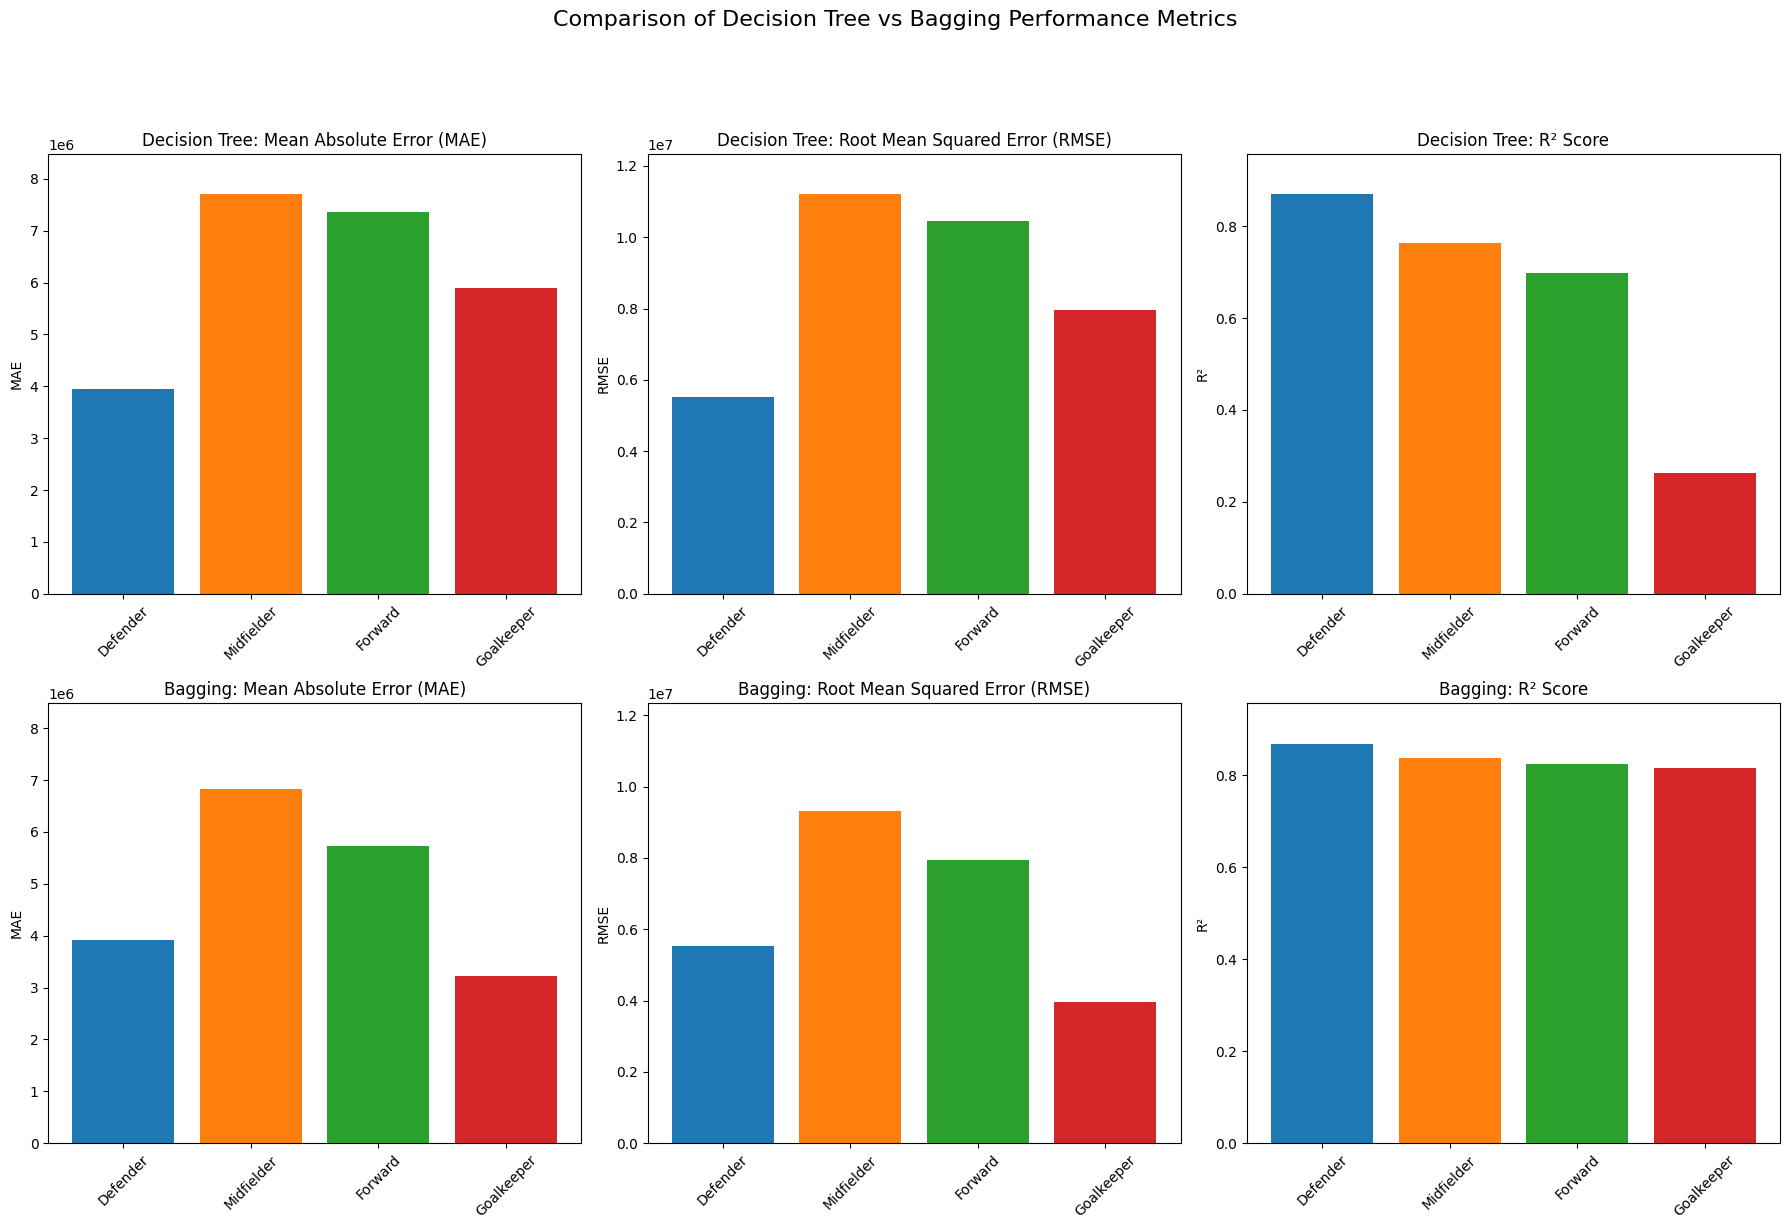

In [ ]:
# Extract metrics for Decision Tree
mae_dt = [results[group]['MAE'] for group in positional_groups]
rmse_dt = [results[group]['Test RMSE'] for group in positional_groups]
r2_dt = [results[group]['R^2'] for group in positional_groups]

# Extract metrics for Bagging
mae_bagging = [results_bagging[group]['MAE'] for group in positional_groups]
rmse_bagging = [results_bagging[group]['Test RMSE'] for group in positional_groups]
r2_bagging = [results_bagging[group]['R^2'] for group in positional_groups]

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparison of Decision Tree vs Bagging Performance Metrics', fontsize=16, y=1.02)

# Set uniform y-limits for each metric
mae_max = max(max(mae_dt), max(mae_bagging))
rmse_max = max(max(rmse_dt), max(rmse_bagging))
r2_max = max(max(r2_dt), max(r2_bagging))

# Top Row: Decision Tree Results
axes[0, 0].bar(positional_groups, mae_dt, color=colors)
axes[0, 0].set_title('Decision Tree: Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_ylim(0, mae_max * 1.1)
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(positional_groups, rmse_dt, color=colors)
axes[0, 1].set_title('Decision Tree: Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_ylim(0, rmse_max * 1.1)
axes[0, 1].tick_params(axis='x', rotation=45)

axes[0, 2].bar(positional_groups, r2_dt, color=colors)
axes[0, 2].set_title('Decision Tree: R² Score')
axes[0, 2].set_ylabel('R²')
axes[0, 2].set_ylim(0, r2_max * 1.1)
axes[0, 2].tick_params(axis='x', rotation=45)

# Bottom Row: Bagging Results
axes[1, 0].bar(positional_groups, mae_bagging, color=colors)
axes[1, 0].set_title('Bagging: Mean Absolute Error (MAE)')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_ylim(0, mae_max * 1.1)
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(positional_groups, rmse_bagging, color=colors)
axes[1, 1].set_title('Bagging: Root Mean Squared Error (RMSE)')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_ylim(0, rmse_max * 1.1)
axes[1, 1].tick_params(axis='x', rotation=45)

axes[1, 2].bar(positional_groups, r2_bagging, color=colors)
axes[1, 2].set_title('Bagging: R² Score')
axes[1, 2].set_ylabel('R²')
axes[1, 2].set_ylim(0, r2_max * 1.1)
axes[1, 2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top spacing to fit the suptitle

The bar plots similarly illustrate that the bagging model performs better across all metrics of accuracy and across all positional groups. The defender's accuracy is very similar across the single decision tree and the bagging model. However, the accuracy of the goalkeeper's group is significantly improved.

*It should also be noted that the baggin model scores a similar R^2 score across all four positional groups.*

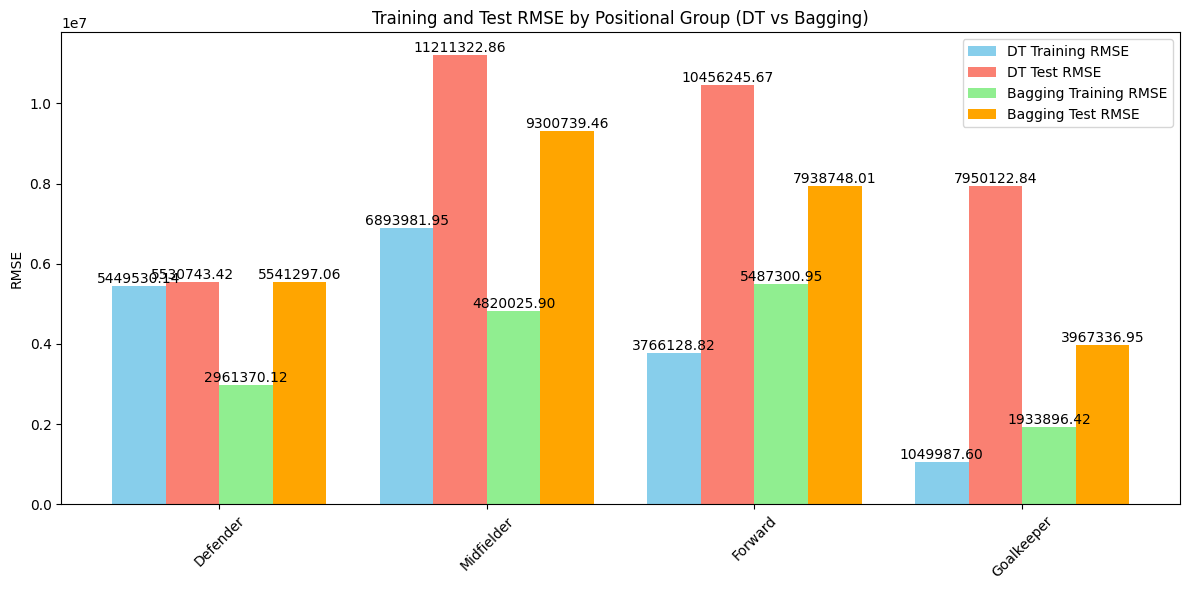

In [ ]:
# Extract RMSE values for Decision Tree
train_rmse_dt = [results[group]['Train RMSE'] for group in positional_groups]
test_rmse_dt = [results[group]['Test RMSE'] for group in positional_groups]

# Extract RMSE values for Bagging
train_rmse_bagging = [results_bagging[group]['Train RMSE'] for group in positional_groups]
test_rmse_bagging = [results_bagging[group]['Test RMSE'] for group in positional_groups]

# Plot settings
x = np.arange(len(positional_groups))  # The label locations
width = 0.2  # Width of each bar

# Create a grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bars for Decision Tree
bars1 = ax.bar(x - width * 1.5, train_rmse_dt, width, label='DT Training RMSE', color='skyblue')
bars2 = ax.bar(x - width / 2, test_rmse_dt, width, label='DT Test RMSE', color='salmon')

# Bars for Bagging
bars3 = ax.bar(x + width / 2, train_rmse_bagging, width, label='Bagging Training RMSE', color='lightgreen')
bars4 = ax.bar(x + width * 1.5, test_rmse_bagging, width, label='Bagging Test RMSE', color='orange')

# Add labels and title
ax.set_ylabel('RMSE')
ax.set_title('Training and Test RMSE by Positional Group (DT vs Bagging)')
ax.set_xticks(x)
ax.set_xticklabels(positional_groups, rotation=45)
ax.legend()

# Annotate bars
for bar in bars1 + bars2 + bars3 + bars4:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()


A look at the differences between training vs test error shows that the bagging model performs better on the test set across all positional groups, except for the defenders. For the defenders, the single decision tree performs marginally better than the bagging model. However, the significant improvements across all other decision groups indicate that the bagging is the more generalizable model.

<a id="feat_imp"></a>
### Feature Importance

**Built-In Feature Importance**

In [ ]:
# Store feature importance for visualization
feature_importance_results = {}

# Loop through each positional group
for group in positional_groups:
    print(f"Calculating feature importance for {group} group...")

    # Filter data for the group
    group_data = data[data['Position_Group'] == group]
    if group_data.empty:
        print(f"No data for group {group}. Skipping...")
        continue

    # Ensure the model exists for the group
    if group not in results_bagging or group not in bagging_models:
        print(f"No trained Bagging model for group {group}. Skipping...")
        continue

    # Compute average and standard deviation of feature importance
    importances_list = [tree.feature_importances_ for tree in bagging_models[group].estimators_]
    feature_importances_mean = np.mean(importances_list, axis=0)
    feature_importances_std = np.std(importances_list, axis=0)

    # Get feature names
    feature_names = group_data.drop(columns=drop_features, errors='ignore').columns

    # Store feature importances in a DataFrame for sorting and visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean Importance': feature_importances_mean,
        'Std Importance': feature_importances_std
    }).sort_values(by='Mean Importance', ascending=False)

    feature_importance_results[group] = importance_df

Calculating feature importance for Defender group...
Calculating feature importance for Midfielder group...
Calculating feature importance for Forward group...
Calculating feature importance for Goalkeeper group...


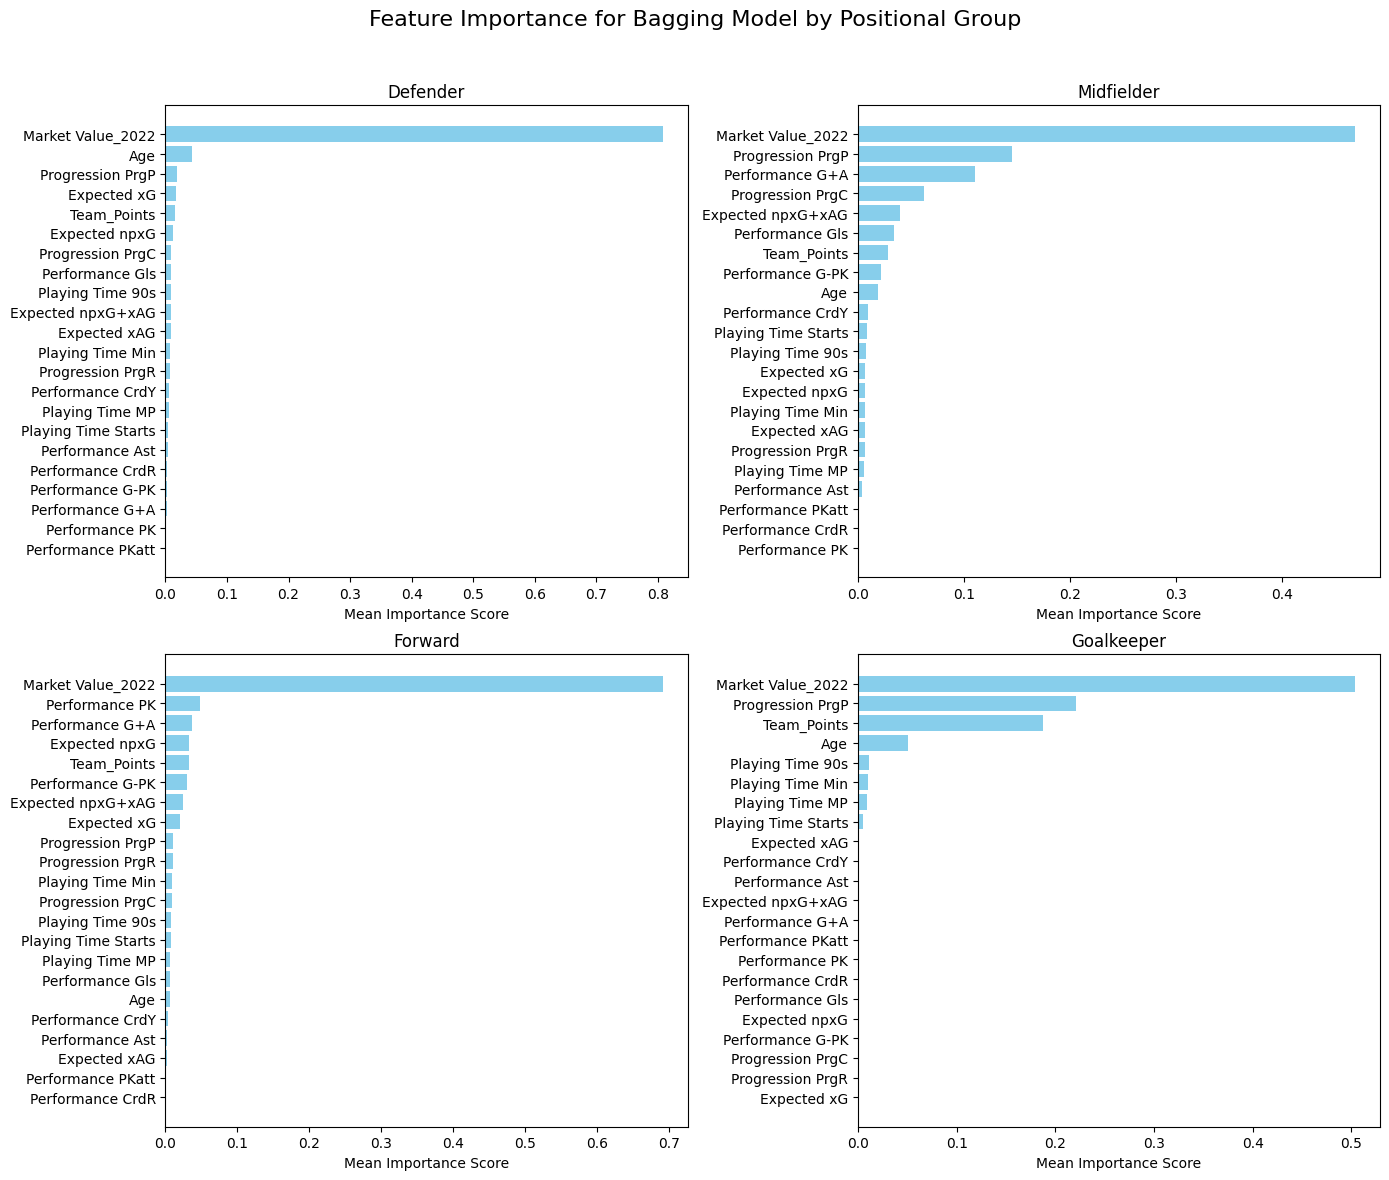

In [ ]:
# Plot all feature importance results in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns grid
fig.suptitle("Feature Importance for Bagging Model by Positional Group", fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot for up to 4 positional groups
for idx, (group, importance_df) in enumerate(feature_importance_results.items()):

    axes[idx].barh(importance_df['Feature'], importance_df['Mean Importance'], color='skyblue')
    axes[idx].set_title(f'{group}')
    axes[idx].set_xlabel('Mean Importance Score')
    axes[idx].invert_yaxis()  # Invert for descending order

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust spacing for the suptitle

The feature importance barplots highlight several noticeable trends:

**Market Value**: The market value from before the season is the most important across all four positional groups. The market value had the highest correlation with the response variable, market value 2023, according to the [correlation matrix](#cor) seen during EDA.



**Feature Importance with Standard Deviations**

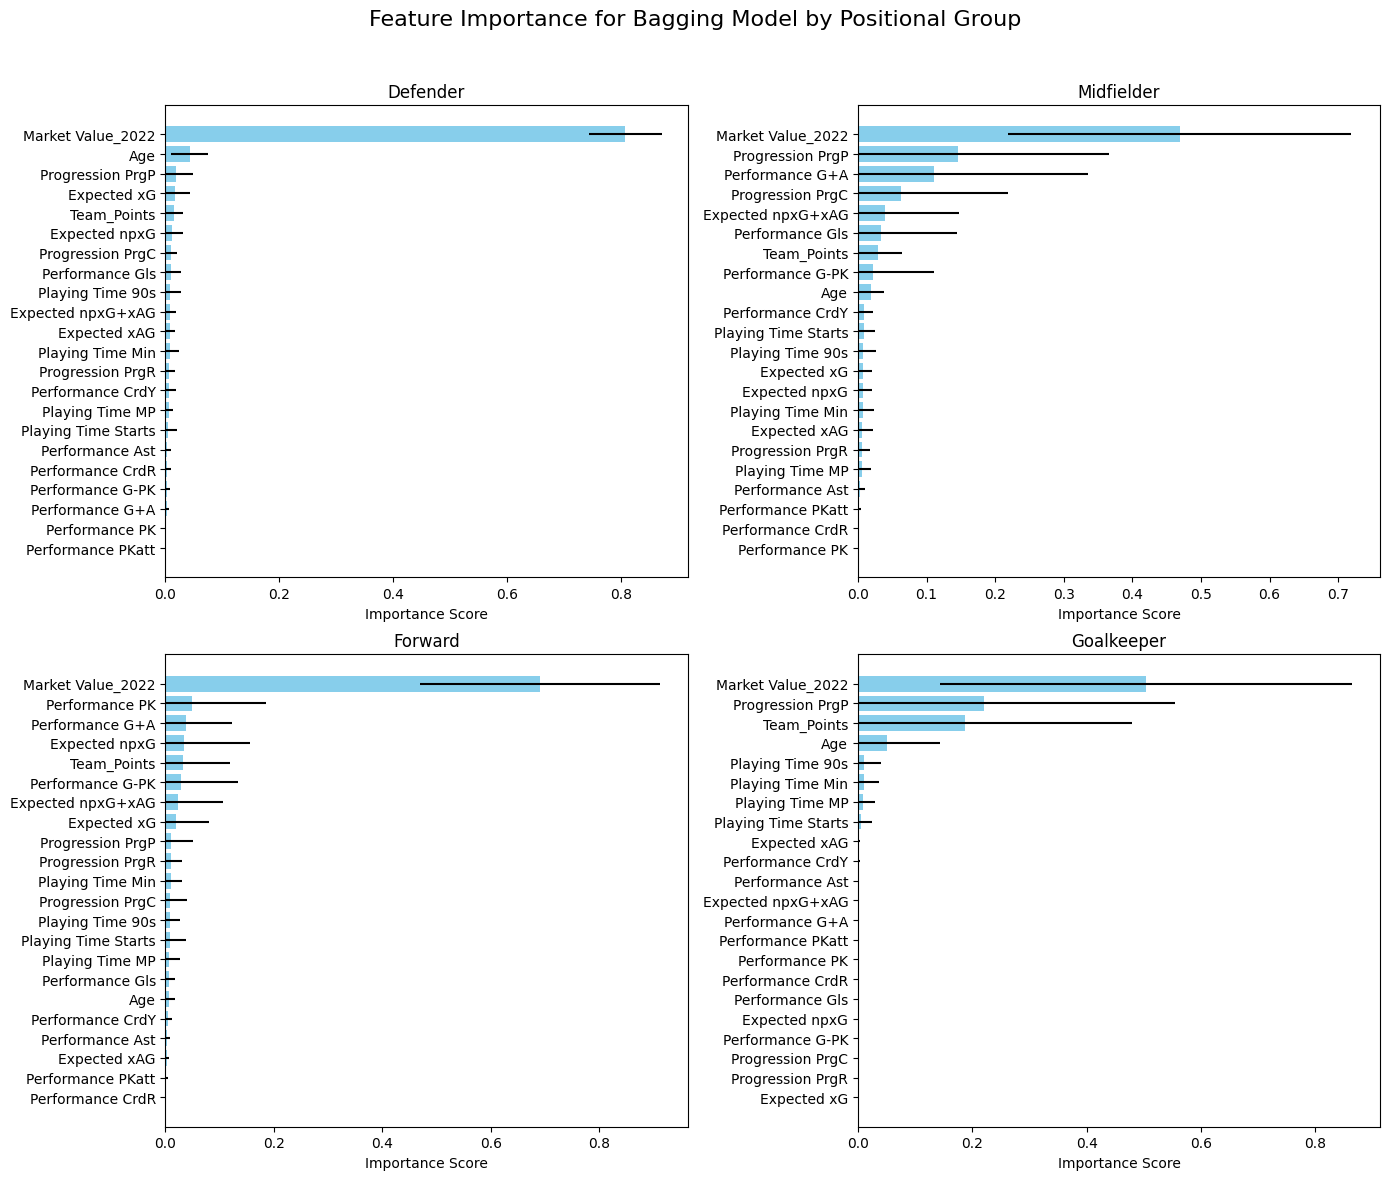

In [ ]:
# Plot all feature importance results in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns grid
fig.suptitle("Feature Importance for Bagging Model by Positional Group", fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot for up to 4 positional groups
for idx, (group, importance_df) in enumerate(feature_importance_results.items()):
    if idx >= 4:  # Stop after plotting 4 groups
        break

    ax = axes[idx]  # Select subplot
    ax.barh(importance_df['Feature'], importance_df['Mean Importance'], xerr=importance_df['Std Importance'], color='skyblue')
    ax.set_title(f'{group}')
    ax.set_xlabel('Importance Score')
    ax.set_xlim(0)
    ax.invert_yaxis()  # Invert for descending order

# Hide any unused subplots if fewer than 4 groups
for idx in range(len(feature_importance_results), 4):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust spacing for the suptitle

Examining the spread of feature importances across all bagged models raises a crucial limitation of our modeling. The majority of features have a standard deviation that includes 0, making it possible that the feature importance is less significant than our calculated averages suggest. This limitation arises from two key dynamics:

First, the previous year's market value is extremely predictive of the response variable in our model. As a result, the performance metrics are all less important for our model. However, excluding the previous market value from our model would significantly decrease our model's accuracy. Thus, we choose to keep the predictor, despite the fact that it is not a performance metrics.

Second, our sample size of data is small enough to make individual outliers significant for the analysis of feature importance. Our boosting model relies on bootstrapped samples of the data, meaning that certain data points may be randomly excluded when training some models. As a results, the wide variety of feature importance scores can reflect the influence of single data points, given our limited sample size.

<a id="feat_eng"></a>

### Feature Engineering

**Calculate Estimate Market Values**

In [ ]:
# Create a new column for the model-estimated market value

# Loop through each positional group to make predictions
for group in positional_groups:
    print(f"Estimating Market Value for {group} group...")

    # Filter the data for the current positional group
    group_data = data[data['Position_Group'] == group]

    # Check if the group has a trained model
    if group in models:
        # Get the trained model for the group
        model = models[group]

        # Prepare the features for prediction (drop unused columns and placeholder)
        X_group = group_data.drop(columns=drop_features + ['Market_Value_Estimated', target], errors='ignore')

        # Ensure column names match those used during training
        X_group = X_group[model.feature_names_in_]  # Align with training features

        # Make predictions using the model
        estimated_values = model.predict(X_group)

        # Assign the predictions to the new column in the original DataFrame
        data.loc[data['Position_Group'] == group, 'Market_Value_Estimated'] = estimated_values
    else:
        print(f"No trained model found for {group}. Skipping...")

# Convert the new column to numeric (just in case)
data['Market_Value_Estimated'] = pd.to_numeric(data['Market_Value_Estimated'], errors='coerce')

Estimating Market Value for Defender group...
Estimating Market Value for Midfielder group...
Estimating Market Value for Forward group...
Estimating Market Value for Goalkeeper group...


In [ ]:
# Display the updated DataFrame
print("\nUpdated DataFrame with Market Value Estimates:")
pd.DataFrame(data.head())


Updated DataFrame with Market Value Estimates:


Player Nation        Squad  Age  Playing Time MP  \
0        Max Aarons    ENG  Bournemouth   23               20   
2       Tyler Adams    USA  Bournemouth   24                3   
3  Tosin Adarabioyo    ENG       Fulham   25               20   
4    Elijah Adebayo    ENG   Luton Town   25               27   
5     Simon Adingra    CIV     Brighton   21               31   

   Playing Time Starts  Playing Time Min  Playing Time 90s  Performance Gls  \
0                   13              1237              13.7                0   
2                    1               121               1.3                0   
3                   18              1617              18.0                2   
4                   16              1419              15.8               10   
5                   25              2222              24.7                6   

   Performance Ast  ...  Per 90 Minutes xAG  Per 90 Minutes xG+xAG  \
0                1  ...                0.06                   0.06   
2                0  ...                0.06                   0.06   
3                0  ...                0.01                   0.05   
4                0  ...                0.04                   0.42   
5                1  ...                0.15                   0.32   

   Per 90 Minutes npxG  Per 90 Minutes npxG+xAG            Position  \
0                 0.00                     0.06          Right-Back   
2                 0.00                     0.06  Defensive Midfield   
3                 0.04                     0.05         Centre-Back   
4                 0.37                     0.42      Centre-Forward   
5                 0.17                     0.32        Right Winger   

   Market Value_2023  Market Value_2022  Team_Points  Position_Group  \
0           16000000         16000000.0           48        Defender   
2           15000000         18000000.0           48      Midfielder   
3           20000000         16000000.0           47        Defender   
4           12000000          6000000.0           26         Forward   
5           30000000         10000000.0           48         Forward   

   Market_Value_Estimated  
0            1.596000e+07  
2            2.020690e+07  
3            1.596000e+07  
4            1.100000e+07  
5            1.666667e+07  

[5 rows x 39 columns]


**Performance Scores**

*Note: We are not considering the previous year's market value, as it is not a performance metric.*

In [ ]:
# Loop through each positional group
for group in positional_groups:
    print(f"Calculating Performance Score for {group} group...")

    # Filter data for the group
    group_data = data[data['Position_Group'] == group]
    if group_data.empty:
        print(f"No data for group {group}. Skipping...")
        continue

    # Retrieve feature importance results
    importance_df = feature_importance_results[group]
    features = importance_df['Feature'].values
    feature_importances = importance_df['Mean Importance'].values

    # Ensure 'Market Value_2022' is excluded
    valid_features = [feat for feat in features if feat != 'Market Value_2022']
    valid_importances = [imp for feat, imp in zip(features, feature_importances) if feat != 'Market Value_2022']

    print(f"Valid Features for {group}: {valid_features}")

    # Extract the valid predictors from the group data
    X_valid = group_data[valid_features]

    # Standardize all predictors (calculate z-scores)
    scaler = StandardScaler()
    X_zscores = scaler.fit_transform(X_valid)

    # Multiply z-scores with their respective feature importances
    weighted_zscores = X_zscores * valid_importances

    # Sum across all predictors to get the final Performance Score
    performance_score = weighted_zscores.sum(axis=1)

    # Add the Performance Score as a new column in the original data DataFrame
    data.loc[data['Position_Group'] == group, 'Performance_Score'] = performance_score

    print(f"Performance Score for {group} calculated and added to DataFrame.\n")

Calculating Performance Score for Defender group...
Valid Features for Defender: ['Age', 'Progression PrgP', 'Expected xG', 'Team_Points', 'Expected npxG', 'Progression PrgC', 'Performance Gls', 'Playing Time 90s', 'Expected npxG+xAG', 'Expected xAG', 'Playing Time Min', 'Progression PrgR', 'Performance CrdY', 'Playing Time MP', 'Playing Time Starts', 'Performance Ast', 'Performance CrdR', 'Performance G-PK', 'Performance G+A', 'Performance PK', 'Performance PKatt']
Performance Score for Defender calculated and added to DataFrame.

Calculating Performance Score for Midfielder group...
Valid Features for Midfielder: ['Progression PrgP', 'Performance G+A', 'Progression PrgC', 'Expected npxG+xAG', 'Performance Gls', 'Team_Points', 'Performance G-PK', 'Age', 'Performance CrdY', 'Playing Time Starts', 'Playing Time 90s', 'Expected xG', 'Expected npxG', 'Playing Time Min', 'Expected xAG', 'Progression PrgR', 'Playing Time MP', 'Performance Ast', 'Performance PKatt', 'Performance CrdR', 'Perf

In [ ]:
# Verify the updated DataFrame
print("\nUpdated DataFrame with Performance Scores:")
pd.DataFrame(data.head())


Updated DataFrame with Performance Scores:


Player Nation        Squad  Age  Playing Time MP  \
0        Max Aarons    ENG  Bournemouth   23               20   
2       Tyler Adams    USA  Bournemouth   24                3   
3  Tosin Adarabioyo    ENG       Fulham   25               20   
4    Elijah Adebayo    ENG   Luton Town   25               27   
5     Simon Adingra    CIV     Brighton   21               31   

   Playing Time Starts  Playing Time Min  Playing Time 90s  Performance Gls  \
0                   13              1237              13.7                0   
2                    1               121               1.3                0   
3                   18              1617              18.0                2   
4                   16              1419              15.8               10   
5                   25              2222              24.7                6   

   Performance Ast  ...  Per 90 Minutes xG+xAG  Per 90 Minutes npxG  \
0                1  ...                   0.06                 0.00   
2                0  ...                   0.06                 0.00   
3                0  ...                   0.05                 0.04   
4                0  ...                   0.42                 0.37   
5                1  ...                   0.32                 0.17   

   Per 90 Minutes npxG+xAG            Position  Market Value_2023  \
0                     0.06          Right-Back           16000000   
2                     0.06  Defensive Midfield           15000000   
3                     0.05         Centre-Back           20000000   
4                     0.42      Centre-Forward           12000000   
5                     0.32        Right Winger           30000000   

   Market Value_2022  Team_Points  Position_Group  Market_Value_Estimated  \
0         16000000.0           48        Defender            1.596000e+07   
2         18000000.0           48      Midfielder            2.020690e+07   
3         16000000.0           47        Defender            1.596000e+07   
4          6000000.0           26         Forward            1.100000e+07   
5         10000000.0           48         Forward            1.666667e+07   

   Performance_Score  
0          -0.095420  
2          -0.399695  
3          -0.029097  
4           0.008622  
5           0.057042  

[5 rows x 40 columns]

We calculate the Performance Scores based on the Feature Importance. Specifically, our formula is based on finding the z-scores of each feature, multiplying it be the weight calculated via feature importance, and summing the weighted z-scores. This gives us a references for player performance based on the most importance performance metrics for each position.

**Spread of Performance Scores**

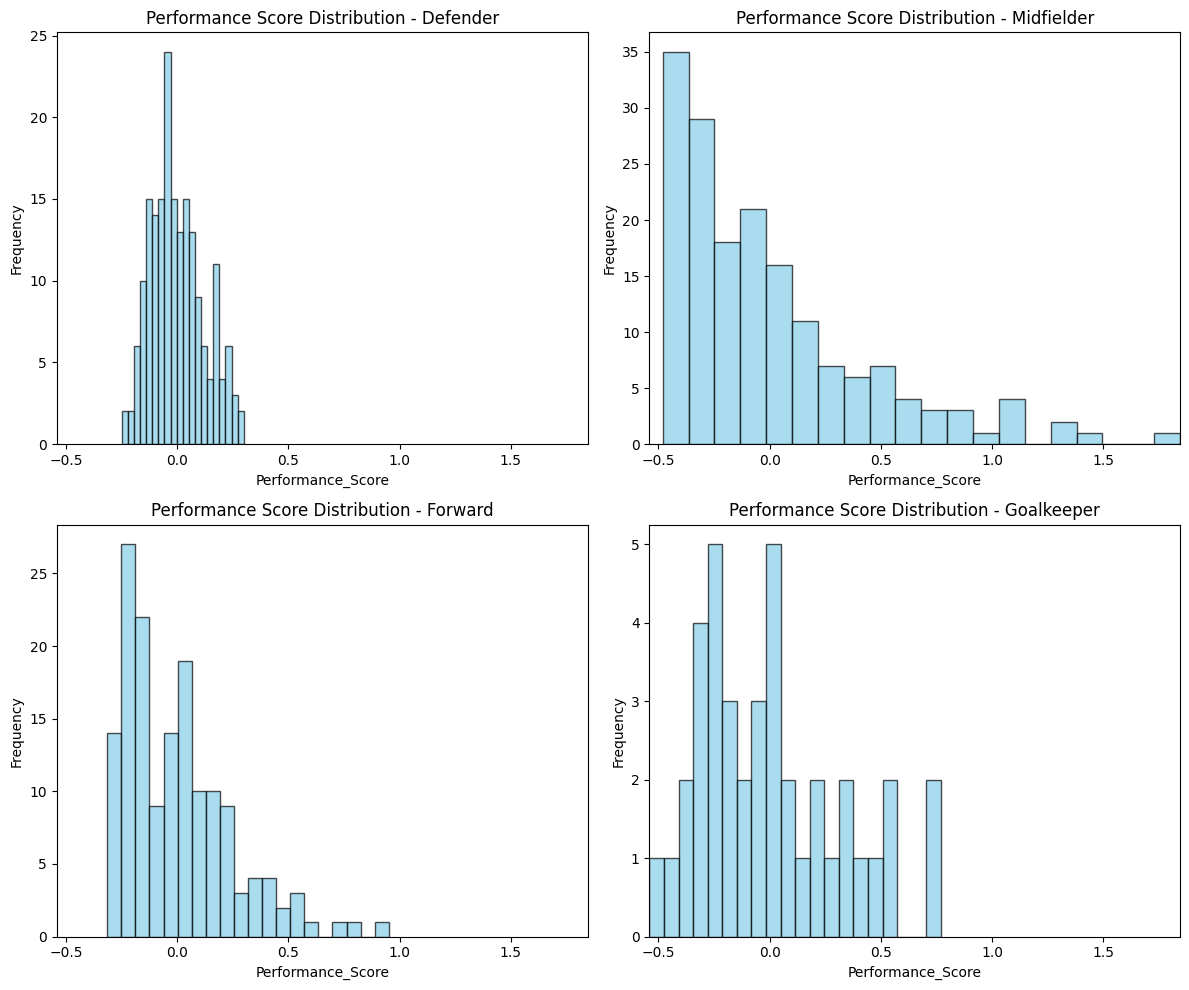

In [ ]:
# Check if 'Performance_Score' column exists
if 'Performance_Score' in data.columns:
    # Define positional groups
    n_groups = len(positional_groups)

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # Flatten axes to iterate easily

    # Calculate global x-axis limits for consistency
    min_x = data['Performance_Score'].min()
    max_x = data['Performance_Score'].max()

    # Plot individual histograms for each positional group
    for i, group in enumerate(positional_groups):
        group_data = data[data['Position_Group'] == group]

        # Plot histogram on its respective subplot
        axes[i].hist(group_data['Performance_Score'], bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        axes[i].set_title(f"Performance Score Distribution - {group}")
        axes[i].set_xlabel("Performance_Score")
        axes[i].set_ylabel("Frequency")

        # Set standardized x-axis limits
        axes[i].set_xlim(min_x, max_x)

    # Hide any unused subplots (if less than 4 groups)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

else:
    print("Performance_Score column does not exist. Please calculate it first.")

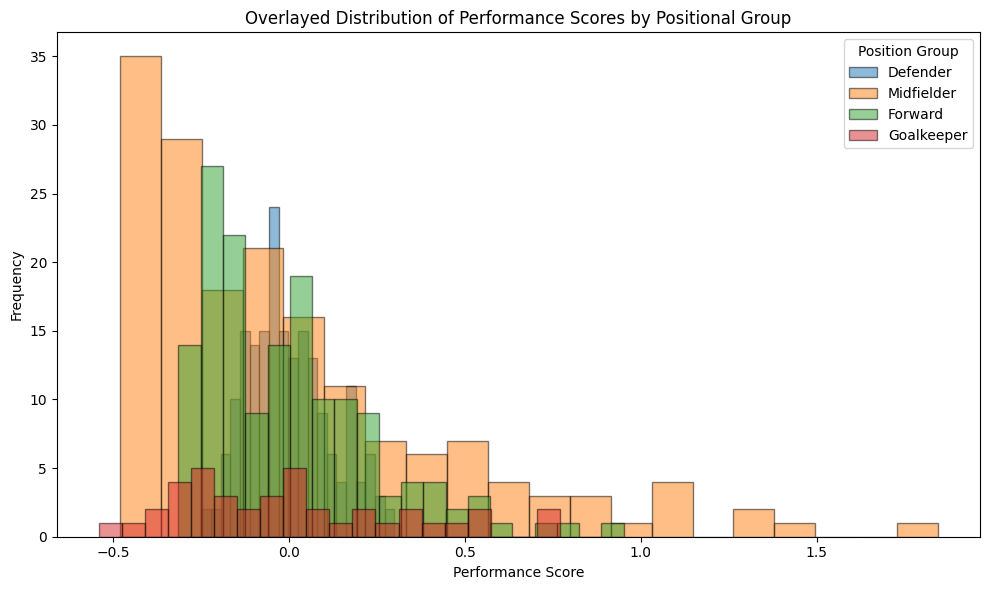

In [ ]:
# Check if 'Performance_Score' column exists
if 'Performance_Score' in data.columns:
    plt.figure(figsize=(10, 6))

    # Plot histograms for each positional group
    for group in positional_groups:
        group_data = data[data['Position_Group'] == group]
        plt.hist(group_data['Performance_Score'], bins=20, alpha=0.5, label=group, edgecolor='black')

    # Add legend and labels
    plt.title("Overlayed Distribution of Performance Scores by Positional Group")
    plt.xlabel("Performance Score")
    plt.ylabel("Frequency")
    plt.legend(title="Position Group")
    plt.tight_layout()

else:
    print("Performance_Score column does not exist. Please calculate it first.")



<a id="perf_bucks"></a>

### Performance Buckets


In [ ]:
# Check if the 'Performance_Score' column exists
if 'Performance_Score' in data.columns:
    # Create an empty column to store the bucket labels
    data['Performance_Bucket'] = None

    # Loop through each positional group
    for group in positional_groups:
        print(f"Creating buckets for {group} group...")

        # Filter data for the current group
        group_data = data[data['Position_Group'] == group]

        # Check if group has at least 5 players
        if len(group_data) >= 5:
            # Divide players into 5 quantile-based buckets
            bucket_labels = [1, 2, 3, 4, 5]  # Buckets: 1 = Lowest, 5 = Highest
            group_buckets = pd.qcut(group_data['Performance_Score'], q=5, labels=bucket_labels)

            # Assign buckets back to the main DataFrame
            data.loc[group_data.index, 'Performance_Bucket'] = group_buckets
        else:
            print(f"Not enough players in {group} to create 5 buckets. Skipping...")

    # Display updated DataFrame
    # print("\nUpdated Data with Performance Buckets:")
    # print(data[['Position_Group', 'Performance_Score', 'Performance_Bucket']])

else:
    print("Performance_Score column does not exist. Please calculate it first.")


Creating buckets for Defender group...
Creating buckets for Midfielder group...
Creating buckets for Forward group...
Creating buckets for Goalkeeper group...


Splitting the player into buckets based on their performance scores gives us 5 buckets per position, each containing players of similar estimated performance scores.

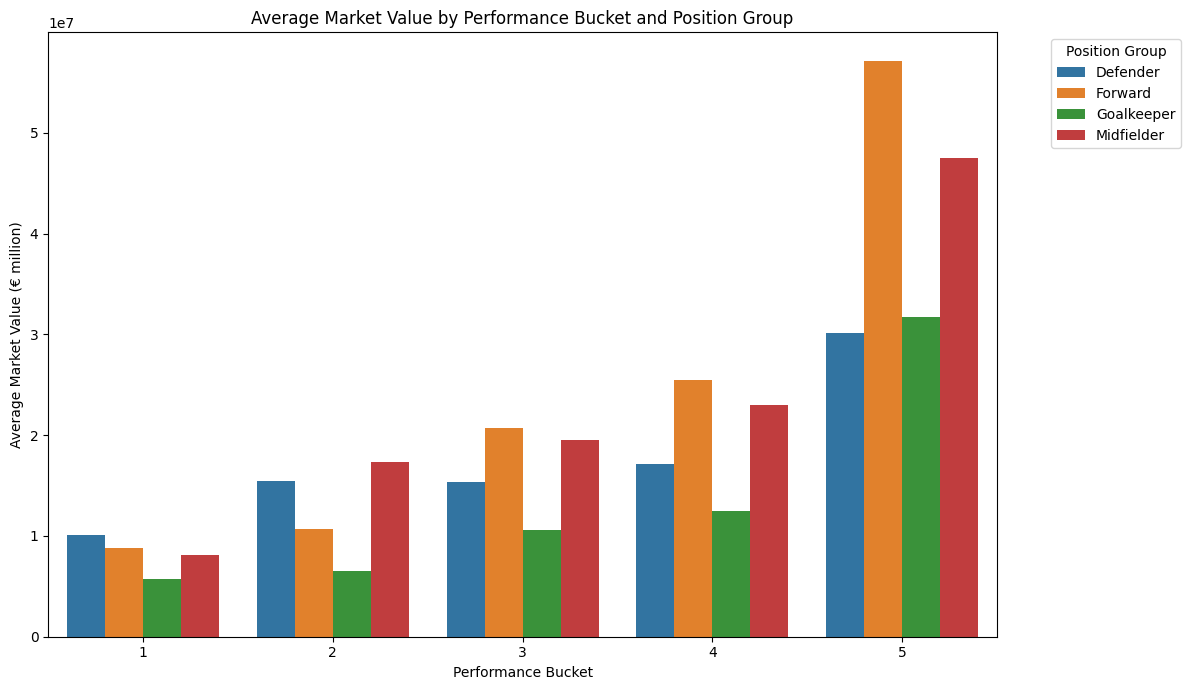

In [ ]:
# Grouped data summary
grouped = data.groupby(['Performance_Bucket', 'Position_Group'])
sum_df = grouped['Market_Value_Estimated'].agg(['count', 'mean']).reset_index()

# Rename columns for clarity
sum_df.rename(columns={'count': 'Player_Count', 'mean': 'Average_Market_Value'}, inplace=True)

# Plot Average Market Value
plt.figure(figsize=(12, 7))
sns.barplot(
    x='Performance_Bucket',
    y='Average_Market_Value',
    hue='Position_Group',
    data=sum_df,
    palette=palette
)

# Add labels and title
plt.title('Average Market Value by Performance Bucket and Position Group')
plt.xlabel('Performance Bucket')
plt.ylabel('Average Market Value (€ million)')
plt.legend(title='Position Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()


The average market value of each performance bucket shows that higher buckets have higher mean market values, making the threshold of being undervalued higher. This is exaclty our intended goal when creating buckets with similar performance scores.

<a id="player_val"></a>
### Player Valuation

In [ ]:
# Check if the necessary columns exist
if 'Performance_Bucket' in data.columns and 'Market_Value_Estimated' in data.columns:
    # Step 1: Calculate the mean and standard deviation per bucket
    bucket_stats = data.groupby('Performance_Bucket')['Market_Value_Estimated'].agg(['mean', 'std']).reset_index()
    bucket_stats.rename(columns={'mean': 'Avg_Market_Value', 'std': 'Market_Value_STD'}, inplace=True)

    # Merge bucket stats back into the original DataFrame
    data = data.merge(bucket_stats, on='Performance_Bucket', how='left')

# Step 2: Categorize players as Overvalued, Undervalued, or Valued
    def label_valuation(row):
        upper_threshold = row['Avg_Market_Value'] + row['Market_Value_STD']
        lower_threshold = row['Avg_Market_Value'] - row['Market_Value_STD']

        if row['Market_Value_Estimated'] > upper_threshold:
            return 'Overvalued'
        elif row['Market_Value_Estimated'] < lower_threshold:
            return 'Undervalued'
        else:
            return 'Valued'

    # Apply the labeling function
    data['Valuation_Status'] = data.apply(label_valuation, axis=1)

else:
    print("Required columns (Performance_Bucket or Market Value_2023) are missing in the data.")


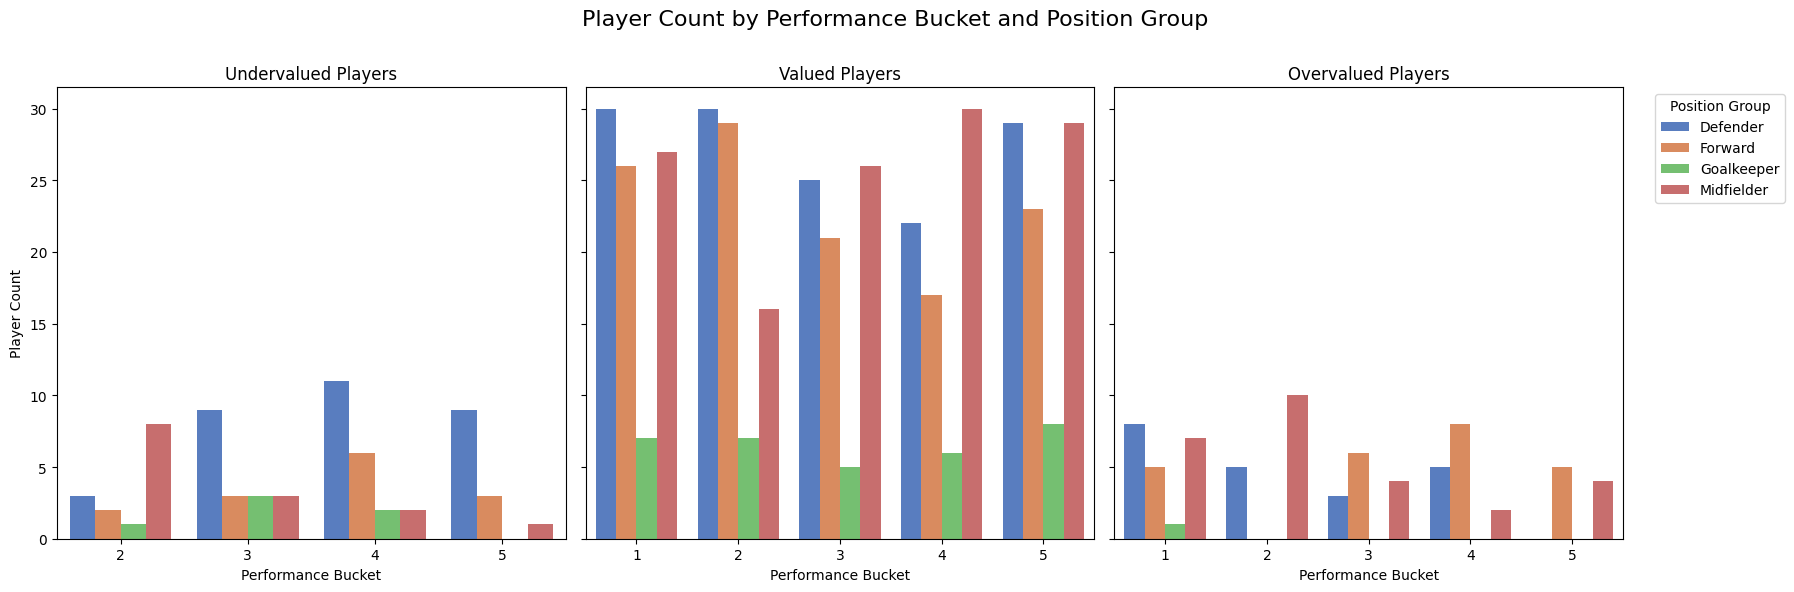

In [ ]:
# Group by 'Position_Group', 'Performance_Bucket', and 'Valuation_Status'
summary = (
    data.groupby(['Position_Group', 'Performance_Bucket', 'Valuation_Status'])
    .size()
    .reset_index(name='Count')
)

# Set up the figure with 3 subplots (one for each Valuation_Status)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Player Count by Performance Bucket and Position Group", fontsize=16)

# Define the three valuation statuses
statuses = ['Undervalued', 'Valued', 'Overvalued']
titles = ['Undervalued Players', 'Valued Players', 'Overvalued Players']

# Create bar plots for each Valuation_Status
for i, status in enumerate(statuses):
    # Filter the data for the current status
    filtered_data = summary[summary['Valuation_Status'] == status]

    # Create the bar plot
    sns.barplot(
        x='Performance_Bucket',
        y='Count',
        hue='Position_Group',
        data=filtered_data,
        palette='muted',
        ax=axes[i]
    )

    # Set titles and labels for each subplot
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Performance Bucket')
    axes[i].set_ylabel('Player Count' if i == 0 else '')  # Only show y-label on the first plot

    # Remove legend for all plots except the last one
    if i < len(statuses) - 1:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(title='Position Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for readability
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust space for the main title

The plots show that the majority of players are considered "valued", whilst a small number of players fall into the "undervalued" and "overvalued" category.

**Undervalued Players**: The majority of players considered undervalued are defenders, primarily from the higher buckets (buckets with higher performance scores). This appears appealing for teams, as it suggests that there are underpriced, high-quality defenders to be bought.

**Overvalued Players**: The majority of overvalued buckets are

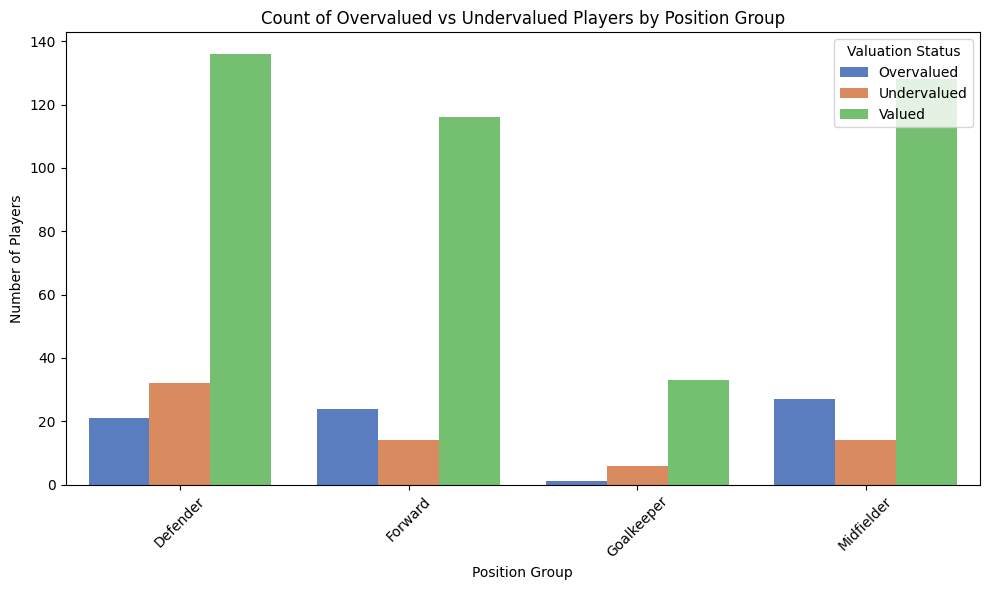

In [ ]:
# Group by 'Position_Group' and 'Valuation_Status' to get the count
summary = (
    data.groupby(['Position_Group', 'Valuation_Status'])
    .size()
    .reset_index(name='Count')
)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Position_Group',
    y='Count',
    hue='Valuation_Status',
    data=summary,
    palette='muted'
)

# Add titles and axis labels
plt.title('Count of Overvalued vs Undervalued Players by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Number of Players')
plt.legend(title='Valuation Status')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Check if the required columns exist
if 'Valuation_Status' in data.columns and 'Position_Group' in data.columns:
    # Step 1: Calculate total players per positional group
    total_players = data.groupby('Position_Group').size().reset_index(name='Total_Players')

    # Step 2: Calculate undervalued players per positional group
    undervalued_players = (
        data[data['Valuation_Status'] == 'Undervalued']
        .groupby('Position_Group')
        .size()
        .reset_index(name='Undervalued_Players')
    )

    # Step 3: Merge total and undervalued player counts
    summary = pd.merge(total_players, undervalued_players, on='Position_Group', how='left')
    summary['Undervalued_Players'].fillna(0, inplace=True)  # Handle groups with no undervalued players

    # Step 4: Calculate the percentage of undervalued players per group
    summary['Percent_Undervalued'] = (summary['Undervalued_Players'] / summary['Total_Players']) * 100

    # Step 5: Add a row for overall totals
    total_players_all = data.shape[0]
    undervalued_players_all = data[data['Valuation_Status'] == 'Undervalued'].shape[0]
    percent_undervalued_all = (undervalued_players_all / total_players_all) * 100

    # Append the total row to the summary DataFrame
    total_row = pd.DataFrame({
        'Position_Group': ['All Groups'],
        'Total_Players': [total_players_all],
        'Undervalued_Players': [undervalued_players_all],
        'Percent_Undervalued': [percent_undervalued_all]
    })

    summary = pd.concat([summary, total_row], ignore_index=True)

    # Display the results
    print("Percentage of Undervalued Players by Position Group (Including Overall Totals):")
    print(summary)

else:
    print("Required columns (Valuation_Status or Position_Group) are missing in the data.")


Percentage of Undervalued Players by Position Group (Including Overall Totals):
  Position_Group  Total_Players  Undervalued_Players  Percent_Undervalued
0       Defender            189                   32            16.931217
1        Forward            154                   14             9.090909
2     Goalkeeper             40                    6            15.000000
3     Midfielder            169                   14             8.284024
4     All Groups            552                   66            11.956522


<ipython-input-213-1c6ff0dbe1a4>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  summary['Undervalued_Players'].fillna(0, inplace=True)  # Handle groups with no undervalued players


In [ ]:
# Check if the required columns exist
if 'Valuation_Status' in data.columns and 'Position_Group' in data.columns:
    # Step 1: Calculate total players per positional group
    total_players = data.groupby('Position_Group').size().reset_index(name='Total_Players')

    # Step 2: Calculate undervalued players per positional group
    overvalued_players = (
        data[data['Valuation_Status'] == 'Overvalued']
        .groupby('Position_Group')
        .size()
        .reset_index(name='Overvalued_Players')
    )

    # Step 3: Merge total and undervalued player counts
    summary = pd.merge(total_players, overvalued_players, on='Position_Group', how='left')
    summary['Overvalued_Players'].fillna(0, inplace=True)  # Handle groups with no undervalued players

    # Step 4: Calculate the percentage of undervalued players per group
    summary['Percent_Overvalued'] = (summary['Overvalued_Players'] / summary['Total_Players']) * 100

    # Step 5: Add a row for overall totals
    total_players_all = data.shape[0]
    overvalued_players_all = data[data['Valuation_Status'] == 'Overvalued'].shape[0]
    percent_overvalued_all = (overvalued_players_all / total_players_all) * 100

    # Append the total row to the summary DataFrame
    total_row = pd.DataFrame({
        'Position_Group': ['All Groups'],
        'Total_Players': [total_players_all],
        'Overvalued_Players': [overvalued_players_all],
        'Percent_Overvalued': [percent_overvalued_all]
    })

    summary = pd.concat([summary, total_row], ignore_index=True)

    # Display the results
    print("Percentage of Overvalued Players by Position Group (Including Overall Totals):")
    print(summary)

else:
    print("Required columns (Valuation_Status or Position_Group) are missing in the data.")

Percentage of Overvalued Players by Position Group (Including Overall Totals):
  Position_Group  Total_Players  Overvalued_Players  Percent_Overvalued
0       Defender            189                  21           11.111111
1        Forward            154                  24           15.584416
2     Goalkeeper             40                   1            2.500000
3     Midfielder            169                  27           15.976331
4     All Groups            552                  73           13.224638


<ipython-input-296-2621f3785114>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  summary['Overvalued_Players'].fillna(0, inplace=True)  # Handle groups with no undervalued players


<a id="infer"></a>

## Conclusions and Inferences

We now can pull out and display our final lists of undervalued players by position. These are the players that answer our driving question of what are the best-valued players a club can sign. We have our conclusion lists sorted by our market values displaying the least expensive players first.

**List of Undervalued Players**

In [ ]:
# Check if the necessary columns exist
if 'Valuation_Status' in data.columns and 'Position_Group' in data.columns:
    # Filter for undervalued players
    undervalued_players = data[data['Valuation_Status'] == 'Undervalued']
    undervalued_player_list = {}

    # Group the undervalued players by Position Group and display them
    print("List of Undervalued Players by Position Group:\n")
    for group, group_data in undervalued_players.groupby('Position_Group'):
        undervalued_player_list[group] = group_data[['Player', 'Position_Group', 'Performance_Bucket', 'Market_Value_Estimated',
                          'Avg_Market_Value', 'Performance_Score']].to_dict(orient='records')
        print(f"Completeted Position Group: {group}")
else:
    print("Required columns (Valuation_Status or Position_Group) are missing in the data.")


List of Undervalued Players by Position Group:

Completeted Position Group: Defender
Completeted Position Group: Forward
Completeted Position Group: Goalkeeper
Completeted Position Group: Midfielder


In [ ]:
pd.DataFrame(undervalued_player_list["Defender"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  \
0        Chris Basham       Defender                   2   
26      James Tomkins       Defender                   2   
21      Jack Robinson       Defender                   4   
20           Tim Ream       Defender                   4   
18       Gabriel Osho       Defender                   3   
6      Séamus Coleman       Defender                   3   
17     Angelo Ogbonna       Defender                   3   
8     Aaron Cresswell       Defender                   3   
13  Mathias Jørgensen       Defender                   4   
11       Paul Dummett       Defender                   2   
23       Thiago Silva       Defender                   5   
16            Ben Mee       Defender                   4   
15        Tom Lockyer       Defender                   3   
9        Craig Dawson       Defender                   5   
5     Nathaniel Clyne       Defender                   3   
3         Reece Burke       Defender                   3   
12        Jonny Evans       Defender                   4   
2          Willy Boly       Defender                   4   
31       Ashley Young       Defender                   5   
28            Vitinho       Defender                   4   
30          Joel Ward       Defender                   4   
7     Vladimír Coufal       Defender                   5   
1        Amari'i Bell       Defender                   3   
24         Adam Smith       Defender                   4   
25      Harry Toffolo       Defender                   4   
10       Matt Doherty       Defender                   4   
14   Jamaal Lascelles       Defender                   3   
19   Emerson Palmieri       Defender                   5   
27    Kieran Trippier       Defender                   5   
29        Kyle Walker       Defender                   5   
4            Dan Burn       Defender                   5   
22       Fabian Schär       Defender                   5   

    Market_Value_Estimated  Avg_Market_Value  Performance_Score  
0             8.444444e+05      1.402056e+07          -0.057294  
26            8.444444e+05      1.402056e+07          -0.063170  
21            8.444444e+05      2.089308e+07           0.063272  
20            8.444444e+05      2.089308e+07           0.080475  
18            8.444444e+05      1.776932e+07          -0.042514  
6             8.444444e+05      1.776932e+07          -0.028339  
17            8.444444e+05      1.776932e+07          -0.029489  
8             8.444444e+05      1.776932e+07          -0.039324  
13            8.444444e+05      2.089308e+07           0.026638  
11            8.444444e+05      1.402056e+07          -0.083607  
23            2.323077e+06      4.312043e+07           0.183976  
16            2.323077e+06      2.089308e+07           0.069503  
15            2.323077e+06      1.776932e+07          -0.022273  
9             2.323077e+06      4.312043e+07           0.104763  
5             2.323077e+06      1.776932e+07          -0.018500  
3             2.323077e+06      1.776932e+07           0.004790  
12            2.323077e+06      2.089308e+07           0.036140  
2             2.323077e+06      2.089308e+07           0.068442  
31            3.500000e+06      4.312043e+07           0.155633  
28            3.500000e+06      2.089308e+07           0.032819  
30            3.500000e+06      2.089308e+07           0.063435  
7             3.500000e+06      4.312043e+07           0.181316  
1             3.500000e+06      1.776932e+07          -0.024288  
24            3.500000e+06      2.089308e+07           0.062445  
25            4.587500e+06      2.089308e+07           0.024125  
10            4.587500e+06      2.089308e+07           0.028702  
14            4.587500e+06      1.776932e+07          -0.011383  
19            1.088235e+07      4.312043e+07           0.181420  
27            1.088235e+07      4.312043e+07           0.246716  
29            1.088235e+07      4.312043e+07          

In [ ]:
pd.DataFrame(undervalued_player_list["Midfielder"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  \
0       Oliver Arblaster     Midfielder                   2   
1       Shandon Baptiste     Midfielder                   2   
2             Luke Berry     Midfielder                   2   
6           Adam Lallana     Midfielder                   3   
7           James Milner     Midfielder                   3   
8      Marvelous Nakamba     Midfielder                   2   
9         Oliver Norwood     Midfielder                   3   
10          Matt Ritchie     Midfielder                   2   
11          Joe Rothwell     Midfielder                   2   
12  Pelly Ruddock Mpanzu     Midfielder                   2   
13       Yehor Yarmoliuk     Midfielder                   2   
3            Tom Cairney     Midfielder                   4   
4     Idrissa Gana Gueye     Midfielder                   4   
5            Pascal Groß     Midfielder                   5   

    Market_Value_Estimated  Avg_Market_Value  Performance_Score  
0             1.283333e+06      1.402056e+07          -0.334927  
1             1.283333e+06      1.402056e+07          -0.318815  
2             1.283333e+06      1.402056e+07          -0.257221  
6             1.283333e+06      1.776932e+07          -0.175678  
7             1.283333e+06      1.776932e+07          -0.089810  
8             1.283333e+06      1.402056e+07          -0.306834  
9             1.283333e+06      1.776932e+07          -0.166533  
10            1.283333e+06      1.402056e+07          -0.267290  
11            1.283333e+06      1.402056e+07          -0.335807  
12            1.283333e+06      1.402056e+07          -0.282712  
13            1.283333e+06      1.402056e+07          -0.306318  
3             2.500000e+06      2.089308e+07           0.224113  
4             2.500000e+06      2.089308e+07           0.126849  
5             2.500000e+06      4.312043e+07           1.116447

In [ ]:
pd.DataFrame(undervalued_player_list["Forward"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  \
2   Jóhann Berg Guðmundsson        Forward                   2   
10            Jay Rodriguez        Forward                   3   
13           Cauley Woodrow        Forward                   2   
1               Jordan Ayew        Forward                   4   
5      Jean-Philippe Mateta        Forward                   5   
7            Carlton Morris        Forward                   5   
9                Bobby Reid        Forward                   4   
11                  Willian        Forward                   4   
0           Michail Antonio        Forward                   4   
3              Ben Brereton        Forward                   3   
4              Raúl Jiménez        Forward                   3   
6           Oliver McBurnie        Forward                   4   
8             Rodrigo Muniz        Forward                   4   
12               Chris Wood        Forward                   5   

    Market_Value_Estimated  Avg_Market_Value  Performance_Score  
2             1.000000e+06      1.402056e+07          -0.132203  
10            1.000000e+06      1.776932e+07          -0.124434  
13            1.000000e+06      1.402056e+07          -0.206227  
1             4.000000e+06      2.089308e+07           0.087196  
5             4.000000e+06      4.312043e+07           0.332773  
7             4.000000e+06      4.312043e+07           0.342738  
9             4.000000e+06      2.089308e+07           0.015626  
11            4.000000e+06      2.089308e+07           0.132466  
0             4.500000e+06      2.089308e+07           0.045786  
3             4.833333e+06      1.776932e+07          -0.029973  
4             4.833333e+06      1.776932e+07           0.007923  
6             4.833333e+06      2.089308e+07           0.036664  
8             4.833333e+06      2.089308e+07           0.078198  
12            7.250000e+06      4.312043e+07           0.192212

In [ ]:
pd.DataFrame(undervalued_player_list["Goalkeeper"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  \
2      Loris Karius     Goalkeeper                   3   
3     Remi Matthews     Goalkeeper                   2   
5       Robin Olsen     Goalkeeper                   4   
0   Martin Dúbravka     Goalkeeper                   3   
1  Łukasz Fabiański     Goalkeeper                   4   
4              Neto     Goalkeeper                   3   

   Market_Value_Estimated  Avg_Market_Value  Performance_Score  
2            3.500000e+05      1.776932e+07          -0.110760  
3            3.500000e+05      1.402056e+07          -0.229109  
5            3.500000e+05      2.089308e+07           0.015219  
0            8.666667e+05      1.776932e+07           0.004961  
1            8.666667e+05      2.089308e+07           0.066658  
4            2.500000e+06      1.776932e+07          -0.079517

Now, with these lists of undervalued players, we would advise teams to initially look into this shortlist of players when considering a transfer. However, we do recognize there are a number of factors off the field that can contribute to the signing of a player.

We can also recognize that our model produces overvalued lists that answers a different question: what players should clubs target to sell instead of buy?

**List of Overvalued Players**

In [ ]:
# Check if the necessary columns exist
if 'Valuation_Status' in data.columns and 'Position_Group' in data.columns:
    # Filter for overvalued players
    overvalued_players = data[data['Valuation_Status'] == 'Overvalued']
    overvalued_player_list = {}

    # Group the overvalued players by Position Group and display them
    print("List of Overvalued Players by Position Group:\n")
    for group, group_data in overvalued_players.groupby('Position_Group'):
        overvalued_player_list[group] = group_data[['Player', 'Position_Group', 'Performance_Bucket', 'Market_Value_Estimated',
                          'Avg_Market_Value', 'Performance_Score']].to_dict(orient='records')
        print(f"Completeted Position Group: {group}")
else:
    print("Required columns (Valuation_Status or Position_Group) are missing in the data.")

List of Overvalued Players by Position Group:

Completeted Position Group: Defender
Completeted Position Group: Forward
Completeted Position Group: Goalkeeper
Completeted Position Group: Midfielder


In [ ]:
pd.DataFrame(overvalued_player_list["Defender"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  \
7       Maxime Estève       Defender                   1   
10         Rico Henry       Defender                   1   
11       Aaron Hickey       Defender                   1   
2      Valentín Barco       Defender                   1   
14        Ian Maatsen       Defender                   1   
6       Radu Drăgușin       Defender                   1   
9          Lewis Hall       Defender                   1   
17     Jurriën Timber       Defender                   1   
16        John Stones       Defender                   4   
15  Lisandro Martínez       Defender                   2   
0        Nayef Aguerd       Defender                   4   
8          Marc Guéhi       Defender                   2   
4        Levi Colwill       Defender                   3   
3         Sven Botman       Defender                   2   
1   Benoît Badiashile       Defender                   2   
19     Raphaël Varane       Defender                   4   
13    Ibrahima Konaté       Defender                   3   
18         Pau Torres       Defender                   4   
20   Micky van de Ven       Defender                   3   
12        Reece James       Defender                   2   
5          Rúben Dias       Defender                   4   

    Market_Value_Estimated  Avg_Market_Value  Performance_Score  
7             1.880000e+07      8.787607e+06          -0.131592  
10            2.400000e+07      8.787607e+06          -0.106604  
11            2.400000e+07      8.787607e+06          -0.149247  
2             2.583333e+07      8.787607e+06          -0.183692  
14            2.583333e+07      8.787607e+06          -0.132432  
6             2.583333e+07      8.787607e+06          -0.158198  
9             2.583333e+07      8.787607e+06          -0.130935  
17            3.657143e+07      8.787607e+06          -0.143790  
16            3.657143e+07      2.089308e+07           0.037304  
15            3.657143e+07      1.402056e+07          -0.101893  
0             3.657143e+07      2.089308e+07           0.033171  
8             3.657143e+07      1.402056e+07          -0.049880  
4             3.657143e+07      1.776932e+07          -0.021259  
3             3.657143e+07      1.402056e+07          -0.048223  
1             3.657143e+07      1.402056e+07          -0.080095  
19            3.657143e+07      2.089308e+07           0.039358  
13            4.750000e+07      1.776932e+07           0.011121  
18            4.750000e+07      2.089308e+07           0.074020  
20            4.750000e+07      1.776932e+07           0.011277  
12            6.785714e+07      1.402056e+07          -0.072044  
5             6.785714e+07      2.089308e+07           0.096448

In [ ]:
pd.DataFrame(overvalued_player_list["Midfielder"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  \
0           Tyler Adams     Midfielder                   1   
18            Gio Reyna     Midfielder                   1   
5   Hamed Junior Traorè     Midfielder                   1   
22        Andrey Santos     Midfielder                   1   
3          Josh Dasilva     Midfielder                   1   
1         Carlos Baleba     Midfielder                   2   
4       Cheick Doucouré     Midfielder                   2   
23     Emile Smith Rowe     Midfielder                   2   
15      Kalvin Phillips     Midfielder                   2   
21      Ibrahim Sangaré     Midfielder                   2   
25          Joe Willock     Midfielder                   2   
7           Roméo Lavia     Midfielder                   1   
8           Mason Mount     Midfielder                   2   
17         Jacob Ramsey     Midfielder                   3   
24        Sandro Tonali     Midfielder                   2   
2     Rodrigo Bentancur     Midfielder                   3   
10        Matheus Nunes     Midfielder                   1   
11        Matheus Nunes     Midfielder                   3   
14          Cole Palmer     Midfielder                   2   
16      Kalvin Phillips     Midfielder                   2   
6         Mateo Kovačić     Midfielder                   4   
9    Christopher Nkunku     Midfielder                   3   
12        João Palhinha     Midfielder                   4   
13          Cole Palmer     Midfielder                   5   
19          Declan Rice     Midfielder                   5   
20                Rodri     Midfielder                   5   
26      Martin Ødegaard     Midfielder                   5   

    Market_Value_Estimated  Avg_Market_Value  Performance_Score  
0             2.020690e+07      8.787607e+06          -0.399695  
18            2.020690e+07      8.787607e+06          -0.388766  
5             2.020690e+07      8.787607e+06          -0.412125  
22            2.020690e+07      8.787607e+06          -0.466739  
3             2.020690e+07      8.787607e+06          -0.423339  
1             2.633333e+07      1.402056e+07          -0.225157  
4             2.929412e+07      1.402056e+07          -0.264776  
23            2.929412e+07      1.402056e+07          -0.225892  
15            2.929412e+07      1.402056e+07          -0.338665  
21            2.929412e+07      1.402056e+07          -0.281006  
25            2.929412e+07      1.402056e+07          -0.259803  
7             2.929412e+07      8.787607e+06          -0.421981  
8             3.566667e+07      1.402056e+07          -0.263903  
17            3.566667e+07      1.776932e+07          -0.118639  
24            3.566667e+07      1.402056e+07          -0.264509  
2             3.566667e+07      1.776932e+07          -0.049871  
10            3.566667e+07      8.787607e+06          -0.379024  
11            3.566667e+07      1.776932e+07          -0.127240  
14            5.250000e+07      1.402056e+07          -0.375624  
16            5.250000e+07      1.402056e+07          -0.314305  
6             5.250000e+07      2.089308e+07           0.088927  
9             5.750000e+07      1.776932e+07          -0.149540  
12            5.750000e+07      2.089308e+07           0.175377  
13            8.000000e+07      4.312043e+07           1.845050  
19            1.166667e+08      4.312043e+07           1.079687  
20            1.166667e+08      4.312043e+07           1.354417  
26            1.166667e+08      4.312043e+07           1.422542

In [ ]:
pd.DataFrame(overvalued_player_list["Forward"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  \
3         Armando Broja        Forward                   1   
12           Alex Iwobi        Forward                   1   
18  Aleksandar Mitrović        Forward                   1   
1                Antony        Forward                   3   
14      Brennan Johnson        Forward                   1   
22         Jadon Sancho        Forward                   1   
2         Harvey Barnes        Forward                   3   
19        Michael Olise        Forward                   4   
4          Moussa Diaby        Forward                   4   
16       Mohammed Kudus        Forward                   4   
23           Ivan Toney        Forward                   3   
7         Evan Ferguson        Forward                   3   
6           Jeremy Doku        Forward                   4   
13        Gabriel Jesus        Forward                   4   
15           Diogo Jota        Forward                   4   
9         Jack Grealish        Forward                   3   
17         Kaoru Mitoma        Forward                   3   
20      Marcus Rashford        Forward                   4   
11       Rasmus Højlund        Forward                   4   
5             Luis Díaz        Forward                   5   
0        Julián Álvarez        Forward                   5   
8            Phil Foden        Forward                   5   
21          Bukayo Saka        Forward                   5   
10       Erling Haaland        Forward                   5   

    Market_Value_Estimated  Avg_Market_Value  Performance_Score  
3             2.275000e+07      8.787607e+06          -0.245640  
12            2.650000e+07      8.787607e+06          -0.249701  
18            2.650000e+07      8.787607e+06          -0.246296  
1             3.125000e+07      1.776932e+07          -0.046004  
14            3.125000e+07      8.787607e+06          -0.267182  
22            3.125000e+07      8.787607e+06          -0.230115  
2             3.500000e+07      1.776932e+07          -0.018903  
19            4.650000e+07      2.089308e+07           0.139564  
4             4.833333e+07      2.089308e+07           0.183520  
16            4.833333e+07      2.089308e+07           0.146351  
23            5.000000e+07      1.776932e+07          -0.019472  
7             5.000000e+07      1.776932e+07          -0.048165  
6             5.500000e+07      2.089308e+07           0.115022  
13            5.500000e+07      2.089308e+07           0.113159  
15            5.500000e+07      2.089308e+07           0.126568  
9             5.500000e+07      1.776932e+07           0.003623  
17            5.500000e+07      1.776932e+07           0.003251  
20            5.750000e+07      2.089308e+07           0.187320  
11            6.500000e+07      2.089308e+07           0.128844  
5             8.250000e+07      4.312043e+07           0.338092  
0             8.250000e+07      4.312043e+07           0.444685  
8             1.566667e+08      4.312043e+07           0.497985  
21            1.566667e+08      4.312043e+07           0.746705  
10            1.566667e+08      4.312043e+07           0.951558

In [ ]:
pd.DataFrame(overvalued_player_list["Goalkeeper"]).sort_values('Market_Value_Estimated')

Player Position_Group  Performance_Bucket  Market_Value_Estimated  \
0  Arijanet Muric     Goalkeeper                   1              20000000.0   

   Avg_Market_Value  Performance_Score  
0      8.787607e+06          -0.382096

### Limitations and Future Work


#### Youth Academy

Whilst there are a vast number of players who play for Premier League academy teams, they often lack the necessary data to properly evaluate them within the context of our model.  These players are young  and have high potential and could be a great source of business for smaller teams. However, they lack the playing time spent in the Premier League, and have too much missing data. In later iterations, we would love to expand the scope of the model such that we could include players from these youth academy teams. Premier League academy teams have produced many of the worlds best and most valuable players.

#### Single Season

We trained our model on just one season of Premier League data, while this was a sufficient amount of data we could expand the scope of our model to take in more context of previous seasons.  This would enable a larger training set of players, and a more historical representation of player valuation. This could be an interesting expansion in the future, to see how players in the current era compete with past players in terms of market values (normalized to account for inflation).

#### Single League

Similar to the previous point, we also only took one league into account. Again, expanding our data set could lead to some more accurate results. There are hundreds of professional leagues, across a number of countries, all of which have a unique player base with their own market valuations. If we expanded our dataset, we could compare players across leagues and see how individual leagues can affect player valuation etc.

#### Future Work

Other than expanding the scope of our dataset and model there are a few ideas we had to improve our work moving forward. We thought it could be interesting to utilize this portion as a backend, and to build a front end tool such that professional teams could outline what type of player they want (E.g. A young goalscorer) and we could output transfer advice. We also thought it could be interesting to model against other sports, to see how players' valuations differ across the major sports. Lastly, we felt it could be interesting to expand our modeling with neural networks to help us with feature selection, but that was not covered in this course. Overall, with more time, the project could have gone into a lot of depth into the greater field of sports statistics, and it is something we want to pursue and expand in the future.